# Explainer Notebook of YoutubeNet Analysis

This notebook contains the code and brief descriptions of everything we did for the analysis of the youtube network. We divided the analysis in four main parts, and a part zero, which described the code that we used to fetch all of the data. The following parts are included:
- Part 0: Fetching the data
- Part 1: Making the graph
- Part 2: Community analysis
- Part 3: Further network analysis
- Part 4: Sentiment analysis

All import statements necessary for the analysis:

In [7]:
import os
import re
import json
import csv
import networkx as nx
from langdetect import detect, LangDetectException
from community import community_louvain
from deep_translator import GoogleTranslator
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import modularity
import matplotlib.pyplot as plt
import numpy as np  
from networkx.algorithms.community.quality import modularity
from scipy.stats import ttest_ind
import math
import string
import nltk
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from googletrans import Translator
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from itertools import combinations
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, TimeoutError
from itertools import islice
from youtube_comment_downloader import YoutubeCommentDownloader
from scipy.stats import pearsonr

## Part 0: Fetching the data

### Fetching the json-files for each country, containing the information to the top 100 videos

In [ ]:
# -*- coding: utf-8 -*-
import os
import csv
import json
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

def main():
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    
    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = ""
   
    # Get credentials and create an API client
    flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
        client_secrets_file, scopes)
    credentials = flow.run_console()
    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)
    
    # Create output folder if it doesn't exist
    output_folder = "top_videos"
    os.makedirs(output_folder, exist_ok=True)
    
    # Load country codes and names from CSV
    country_codes = []
    country_names = []
    with open("all_countries.csv", "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row:  # Ensure the row is not empty
                country_codes.append(row[0])
                country_names.append(row[1])

    # Iterate over each country code and fetch the most popular videos with pagination
    for code, name in zip(country_codes, country_names):
        # Define the JSON file path for this country
        filename = f"{name.replace(' ', '_')}_{code}.json"
        filepath = os.path.join(output_folder, filename)
        
        # Check if the JSON file already exists
        if os.path.isfile(filepath):
            print(f"Data for {name} ({code}) already exists. Skipping.")
            continue  # Skip to the next country

        all_results = []  # To store all results for this country
        next_page_token = None  # Initialize next page token
        
        try:
            while True:
                # Make the API request with the current page token
                request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                    chart="mostPopular",
                    regionCode=code,
                    maxResults=50,  # Adjust maxResults as needed
                    pageToken=next_page_token
                )
                response = request.execute()
                
                # Add the items from the current page to all_results
                all_results.extend(response['items'])
                
                # Check if there is a next page; if not, exit the loop
                next_page_token = response.get('nextPageToken')
                if not next_page_token:
                    break  # Exit loop if no more pages

            # Save all results to a JSON file
            with open(filepath, "w") as json_file:
                json.dump(all_results, json_file, indent=4)
            print(f"Saved data for {name} to {filepath}")
        
        except HttpError as e:
            print(f"Failed to retrieve data for {name} ({code}). Skipping this region. Error: {e}")

if __name__ == "__main__":
    main()


### Filtering videos without tags

In [ ]:

# Define the input and output directories
input_dir = "top_videos"
output_dir = "top_videos_filtered"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate over each JSON file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.json'):
        input_filepath = os.path.join(input_dir, filename)
        
        # Load the JSON data from the file
        with open(input_filepath, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Filter out videos that do not have tags
        filtered_videos = [video for video in data if 'tags' in video.get('snippet', {})]
        
        # Define the output file path with the same name in the output directory
        output_filepath = os.path.join(output_dir, filename)
        
        # Save the filtered data to the output file
        with open(output_filepath, 'w', encoding='utf-8') as file:
            json.dump(filtered_videos, file, indent=4, ensure_ascii=False)
        
        print(f"Filtered {len(filtered_videos)} videos with tags and saved to {output_filepath}")


### Fetching and translating the transcripts for each video per country

In [ ]:
country_folder = "Spain_ES"#
json_path = "top_videos_filtered_v3/complete/Spain_ES.json"
print(json_path)
output_directory = "video_transcripts"
os.makedirs(output_directory, exist_ok=True)

country_folder = os.path.join(output_directory, country_folder)
os.makedirs(country_folder, exist_ok=True)

# Load video data
with open(json_path, "r", encoding="utf-8") as file:
    video_data = json.load(file)

# Process each video
for video in video_data:
    video_id = video.get("id")
    if not video_id:
        continue
    
    text_file_path = os.path.join(country_folder, f"{video_id}.txt")
    if os.path.exists(text_file_path):
        print(f"Transcript for video {video_id} already exists. Skipping.")
        continue

    try:
        # Retrieve available transcripts
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)

        # Fetch and translate transcripts
        all_transcripts = []
        for transcript in transcript_list:
            try:
                translated_transcript = transcript.translate('en').fetch()
                all_transcripts.append(translated_transcript)
            except Exception as e:
                print(f"Could not fetch or translate transcript for {transcript.language_code}: {e}")

        # Aggregate all transcripts into a single text
        aggregated_text = ""
        for transcript in all_transcripts:
            aggregated_text += " ".join([item['text'] for item in transcript]) + " "

        # Save the aggregated text only if it's non-empty
        if aggregated_text.strip():
            with open(text_file_path, "w", encoding="utf-8") as text_file:
                text_file.write(aggregated_text.strip())
            print(f"Saved transcript for video {video_id}.")
        else:
            print(f"No valid transcript data found for video {video_id}. Skipping save.")

    except TranscriptsDisabled:
        print(f"Transcripts are disabled for video {video_id}. Skipping.")
    except Exception as e:
        print(f"Failed to retrieve transcript for video {video_id}. Error: {e}")


### Fetching and translating 100 comments for each video per country

In [ ]:
# Initialize downloader and translator
downloader = YoutubeCommentDownloader()
translator = GoogleTranslator()  # ADDED: Initialize the Google Translator from deep_translator

# Define the path to the folder containing the JSON files
top_videos_folder = 'Data/country_files'

# Specify the country to process (set this to the country you want to process)
target_country = "Poland_PL"

# Create a main output folder for storing the comments
output_folder = 'Data/video_comments'
os.makedirs(output_folder, exist_ok=True)

# Define a regex pattern to check for comments that are only emojis
emoji_pattern = re.compile(r'^[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+$')

mention_pattern = re.compile(r'^@\S+\s*')

# Function to check if a comment is only emojis
def is_only_emojis(text):
    return bool(emoji_pattern.match(text))

# Function to download comments with timeout
def download_comments_with_timeout(video_id):
    try:
        # Set a timeout of 30 seconds for downloading comments
        with ThreadPoolExecutor() as executor:
            future = executor.submit(
                downloader.get_comments_from_url, f'https://www.youtube.com/watch?v={video_id}', sort_by=1
            )
            return future.result(timeout=30)
    except TimeoutError:
        print(f"Timeout occurred for video {video_id}")
        return []

# Construct the file path for the specified country JSON file
country_file_path = os.path.join(top_videos_folder, f"{target_country}.json")
if not os.path.isfile(country_file_path):
    print(f"File for {target_country} not found in {top_videos_folder}. Please check the file name.")
else:
    country_folder = os.path.join(output_folder, target_country)
    os.makedirs(country_folder, exist_ok=True)  # Create a folder for the specified country

    # Open and read the JSON file
    with open(country_file_path, 'r') as f:
        video_data = json.load(f)

    # Loop through the first 100 videos in the JSON data
    for index, video in enumerate(islice(video_data, 100)):
        video_id = video.get("id")  # Accessing the 'id' field of each video entry
        if not video_id:
            continue

        # Check if comments file already exists for this video ID
        output_path = os.path.join(country_folder, f'{video_id}.txt')
        if os.path.isfile(output_path):
            print(f"Comments for video {video_id} already exist. Skipping.")
            continue

        # Attempt to get comments with a timeout
        comments = download_comments_with_timeout(video_id)
        if not comments:
            print(f"No comments downloaded for video {video_id}. Skipping due to timeout or empty response.")
            continue

        # Filter and save top 200 English or translated comments that are at least 10 characters and not only emojis
        filtered_comments = []
        for comment in comments:
            text = comment['text']
            # print(f"Original comment text: {text}")
            text = mention_pattern.sub('', text).strip()

            # Check if comment is at least 10 characters and not only emojis
            if len(text) >= 10 and not is_only_emojis(text):
                try:
                    # Check if comment is in English
                    if detect(text) == 'en':
                        filtered_comments.append(text)
                    else:
                        # ADDED: Translate non-English comment to English using deep_translator
                        translated_text = translator.translate(text, target='en')  # CHANGE: Use deep_translator here
                        filtered_comments.append(translated_text)  # CHANGE: Add the translated comment
                        
                except LangDetectException:
                    continue  # Skip if language detection fails
                except Exception as e:
                    print(f"Error detecting language or translating comment: {e}")  # CHANGE
                    continue

            if len(filtered_comments) >= 100:
                break  # Stop once we have 100 comments

        # ADDED: Skip videos with fewer than 50 comments
        if len(filtered_comments) < 50:
            print(f"Skipping video {video_id} as it has only {len(filtered_comments)} comments.")
            continue  # Skip saving and go to the next video

        # Save filtered comments to a text file if there are 50 or more comments
        with open(output_path, 'w', encoding='utf-8') as outfile:
            for comment in filtered_comments:
                outfile.write(f"{comment}\n")

        # Progress message every 10 videos
        if (index + 1) % 10 == 0:
            print(f"Processed {index + 1} videos for {target_country}.")

    # Print message when the specified country's processing is complete
    print(f"Finished processing comments for {target_country}")

## Part 1: Making the graph

### Loading the json-files, comment-files and transcript-files for each node, making a node with all the attibutes (and translated description and tags) and storing it in a node-json file in the node_files folder: 

In [3]:
translator = GoogleTranslator()

# Paths to the folders
comments_base_path = "Data/video_comments"  # Folder containing country folders with comments
transcripts_base_path = "Data/video_transcripts"  # Folder containing country folders with transcripts
json_folder = "Data/country_files" # Folder containing the json-files for each country
node_files_folder = "Data/node_files"  # Folder where node data will be saved

# Create the node_files folder if it doesn't exist
if not os.path.exists(node_files_folder):
    os.makedirs(node_files_folder)

# Iterate over country folders in the comments directory
country_folders = [folder for folder in os.listdir(comments_base_path) if os.path.isdir(os.path.join(comments_base_path, folder))]

print("Nr. of countries:", len(country_folders))

# Total number of processed videos
count = 0 

for country_folder in country_folders:
    comments_country_path = os.path.join(comments_base_path, country_folder)
    transcripts_country_path = os.path.join(transcripts_base_path, country_folder)  # Corresponding transcript folder
    country_name = country_folder
    
    # Load the corresponding JSON file for video data
    json_file_path = os.path.join(json_folder, f"{country_name}.json")
    with open(json_file_path, 'r', encoding='utf-8') as f:
        video_data = json.load(f)

    # Map video ID to its attributes
    video_attributes = {
        video['id']: {
            "title": video.get('snippet', {}).get('title', ''),
            "channelTitle": video.get('snippet', {}).get('channelTitle', ''),
            "viewCount": video.get('statistics', {}).get('viewCount', '0'),
            "likeCount": video.get('statistics', {}).get('likeCount', '0'),
            "publishedAt": video.get('snippet', {}).get('publishedAt', ''),
            "tags": video.get('snippet', {}).get('tags', []),
            "categoryId": video.get('snippet', {}).get('categoryId', '')
        }
        for video in video_data
    }

    # Iterate over txt files in the comments folder
    txt_files = [file for file in os.listdir(comments_country_path) if file.endswith('.txt')]
    count += len(txt_files)

    for txt_file in txt_files:
        video_name = os.path.splitext(txt_file)[0]

        # Read comments from the txt file
        txt_file_path = os.path.join(comments_country_path, txt_file)
        with open(txt_file_path, 'r', encoding='utf-8') as f:
            comments = f.read()

        # Check for transcript file
        transcript_file_path = os.path.join(transcripts_country_path, f"{video_name}.txt")
        transcript = None
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as f:
                transcript = f.read()

        # Define the node file path
        node_file_path = os.path.join(node_files_folder, f"{video_name}.json")

        # If the node already exists, update only the country attribute
        if os.path.exists(node_file_path):
            with open(node_file_path, 'r', encoding='utf-8') as f:
                node_data = json.load(f)

            if 'country' not in node_data:
                node_data['country'] = []
            if country_name not in node_data['country']:
                node_data['country'].append(country_name)

            # Save the updated node
            with open(node_file_path, 'w', encoding='utf-8') as f:
                json.dump(node_data, f, ensure_ascii=False, indent=4)

            continue

        # Create a new node
        node_data = {
            "comments": comments,
            "country": [country_name],
        }

        if transcript:
            node_data["transcript"] = transcript

        # Add video attributes if they exist
        if video_name in video_attributes:
            video_info = video_attributes[video_name]
            node_data.update(video_info)

            # Translate tags if necessary
            tags = video_info.get("tags", [])
            translated_tags = []
            for tag in tags:
                try:
                    if detect(tag) != "en":
                        translated_tags.append(translator.translate(tag, source="auto", target="en"))
                    else:
                        translated_tags.append(tag)
                except Exception as e:
                    translated_tags.append(tag)
            node_data["tags"] = translated_tags

        # Save the new node
        with open(node_file_path, 'w', encoding='utf-8') as f:
            json.dump(node_data, f, ensure_ascii=False, indent=4)
            
print(f"Total videos processed: {count}")

Nr. of countries: 80
Total videos processed: 7364


### Loading the network from the "node_files" folder (using the json-files of the nodes), adding weighted edges based on the tags:

In [4]:
# Initialize the graph
G = nx.Graph()

# Path to the folder with saved node files
node_files_folder = "Data/node_files"

# Load the node information from the "node_files" folder
node_files = [file for file in os.listdir(node_files_folder) if file.endswith('.json')]

# Iterate over each saved node file to load attributes and build the graph
for node_file in node_files:
    node_file_path = os.path.join(node_files_folder, node_file)
    
    with open(node_file_path, 'r', encoding='utf-8') as f:
        node_data = json.load(f)
    
    video_name = os.path.splitext(node_file)[0]
    
    # Add node to the graph with the loaded attributes
    G.add_node(video_name, **node_data)

# Define the threshold for edge weight
threshold = 0.03  # Adjust this value

# Add weighted edges based on shared tags
nodes = list(G.nodes(data=True))
for i, (node1, attr1) in enumerate(nodes):
    tags1 = set(attr1.get('tags', []))
    for j in range(i + 1, len(nodes)):
        node2, attr2 = nodes[j]
        tags2 = set(attr2.get('tags', []))
        
        # Calculate the weight as [number of shared tags] / [sum of tags of the two nodes]
        shared_tags = tags1 & tags2
        weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
        
        # Add the edge only if the weight is above the threshold
        if weight > threshold:
            G.add_edge(node1, node2, weight=weight)

print("Total number of nodes:", G.number_of_nodes())

# Remove isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# Print network summary
print("Total number of nodes after removing isolated ones:", G.number_of_nodes())
print("Total number of edges:", G.number_of_edges())

Total number of nodes: 2972
Total number of nodes after removing isolated ones: 2458
Total number of edges: 23600


ADD: comment on output

### Plotting the number of edges per threshold to determine a threshold that makes the network less dense without making it too sparse:

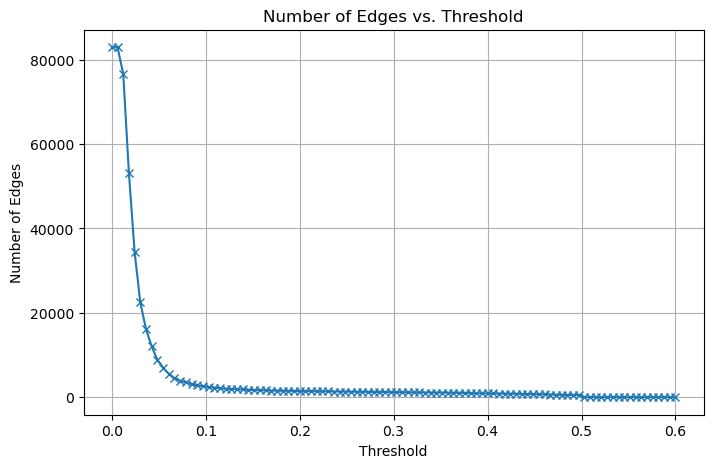

In [59]:
# Define a range of thresholds to evaluate
thresholds = np.linspace(0, 0.6, 100)  # 100 thresholds between 0 and 0.6 (afterwards are barely ay edges)
edge_counts = []

# Evaluate the number of edges for each threshold
for threshold in thresholds:
    temp_graph = nx.Graph()
    
    # Add edges to the temporary graph based on the current threshold
    for i, (node1, attr1) in enumerate(nodes):
        tags1 = set(attr1.get('tags', []))
        for j in range(i + 1, len(nodes)):
            node2, attr2 = nodes[j]
            tags2 = set(attr2.get('tags', []))
            
            shared_tags = tags1 & tags2
            weight = len(shared_tags) / (len(tags1) + len(tags2)) if (len(tags1) + len(tags2)) > 0 else 0
            
            if weight > threshold:
                temp_graph.add_edge(node1, node2, weight=weight)
    
    # Record the number of edges for this threshold
    edge_counts.append(temp_graph.number_of_edges())

# Plot the threshold vs. edge count
plt.figure(figsize=(8, 5))
plt.plot(thresholds, edge_counts, marker='x')
plt.xlabel("Threshold")
plt.ylabel("Number of Edges")
plt.title("Number of Edges vs. Threshold")
plt.grid(True)
plt.show()


### Plotting the degree distribution including the average degree:

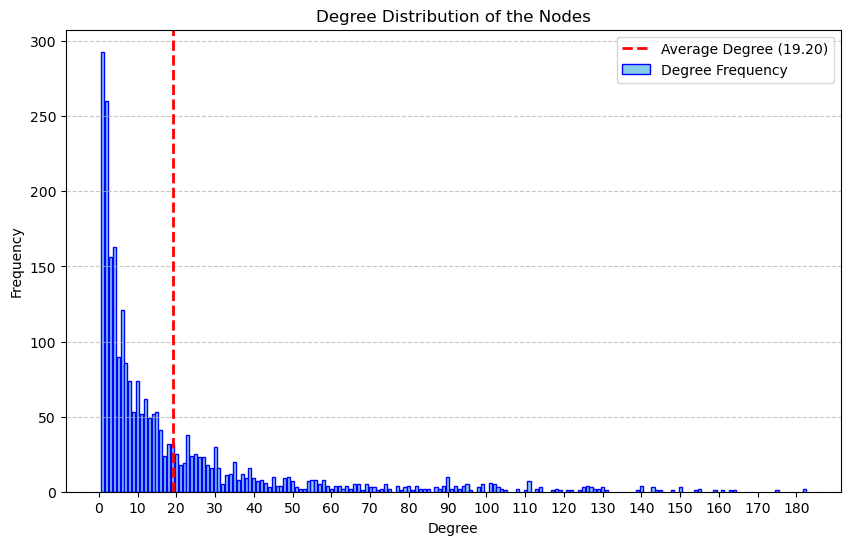

In [62]:
# Calculate degree distribution
degree_sequence = [G.degree(n) for n in G.nodes]
degree_count = {deg: degree_sequence.count(deg) for deg in set(degree_sequence)}
degrees, counts = zip(*sorted(degree_count.items()))

# Calculate the average degree
average_degree = sum(degree_sequence) / len(degree_sequence)

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.bar(degrees, counts, width=0.8, color='skyblue', edgecolor='blue', label='Degree Frequency')

# Add a red dashed line for the average degree
plt.axvline(x=average_degree, color='red', linestyle='--', linewidth=2, label=f'Average Degree ({average_degree:.2f})')

plt.title("Degree Distribution of the Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")

# Set x-ticks every 10
max_degree = max(degrees)
plt.xticks(np.arange(0, max_degree + 1, 10))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In the figure we can see that ADD

## Part 2: Community analysis 

### Determining the structural communities based on the Python Louvain-algorithm and calculating its modularity:

In [77]:
# Using Louvain to find communities
louvain_partition = community_louvain.best_partition(G)

# Calculating the modularity
partition_louvain = {}
for node, community in louvain_partition.items():
    if community not in partition_louvain:
        partition_louvain[community] = []
    partition_louvain[community].append(node)

# Convert partition into a list of sets for modularity calculation
partition_list_louvain = [set(nodes) for nodes in partition_louvain.values()]
modularity_value_louvain = nx.algorithms.community.quality.modularity(G, partition_list_louvain)

print(f"Number of Louvain communities detected: {len(partition_louvain)}")
print(f"Louvain modularity: {modularity_value_louvain:.5f}")

# Function to merge communities if max_communities is exceeded
def merge_communities(partition_dict, max_communities):
    while len(partition_dict) > max_communities:
        # Find the two smallest communities
        smallest = sorted(partition_dict.items(), key=lambda x: len(x[1]))[:2]
        (key1, nodes1), (key2, nodes2) = smallest
        
        # Merge them
        merged_nodes = nodes1 + nodes2
        partition_dict[key1] = merged_nodes
        del partition_dict[key2]
    
    return partition_dict

# Set a maximum number of communities
max_communities = 30  # Adjust as needed
partition_louvain = merge_communities(partition_louvain, max_communities)

# Rename communities to sequential integers (1 to 30)
community_mapping = {old_id: new_id for new_id, old_id in enumerate(partition_louvain.keys(), start=1)}

# Update node assignments with the new community IDs
final_partition = {}
for community, nodes in partition_louvain.items():
    new_community_id = community_mapping[community]
    for node in nodes:
        final_partition[node] = new_community_id

# Recalculate modularity with the renamed partition
partition_list_final = [set(nodes) for nodes in partition_louvain.values()]
modularity_value_final = nx.algorithms.community.quality.modularity(G, partition_list_final)

# Displaying results
print(f"Number of Louvain communities after merging: {len(partition_louvain)}")
print(f"Louvain modularity after merging: {modularity_value_final:.5f}")

# Save the updated community assignments to nodes
nx.set_node_attributes(G, final_partition, "louvain-community")


Number of Louvain communities detected: 180
Louvain modularity: 0.76752
Number of Louvain communities after merging: 30
Louvain modularity after merging: 0.76480


ADD: comment on output

### Determining communities and their modularities based on the country (only taken the first country in the list) and categoryId:

In [72]:
# Community Assignment by `country`
country_partition = {}
for node, data in G.nodes(data=True):
    countries = data.get('country', [])
    primary_country = countries[0] if countries else 'Unknown'  # Use the first country if available
    data['country_community'] = primary_country
    country_partition[node] = primary_country  # Record the primary country for modularity calculation

# Community Assignment by `CategoryID`
category_partition = {}
for node, data in G.nodes(data=True):
    category = data.get('categoryId', [])
    data['category_community'] = category
    category_partition[node] = category  # Record the catefory for modularity calculation

# Modularity calculation for `country_community`
country_communities = {c: [] for c in set(country_partition.values())}
for node, community in country_partition.items():
    country_communities[community].append(node)
country_modularity = modularity(G, country_communities.values())
print(f"Modularity for Country communities: {country_modularity:.4f}")

# Modularity calculation for `category id`
category_communities = {c: [] for c in set(category_partition.values())}
for node, community in category_partition.items():
    category_communities[community].append(node)
category_modularity = modularity(G, category_communities.values())
print(f"Modularity for Category communities: {category_modularity:.4f}")


Modularity for Country communities: 0.2692
Modularity for Category communities: 0.4721


ADD: comment on output

### Comparing the Louvain communities with the category partition by making a confusion matrix D and visualizing it using a heat map:

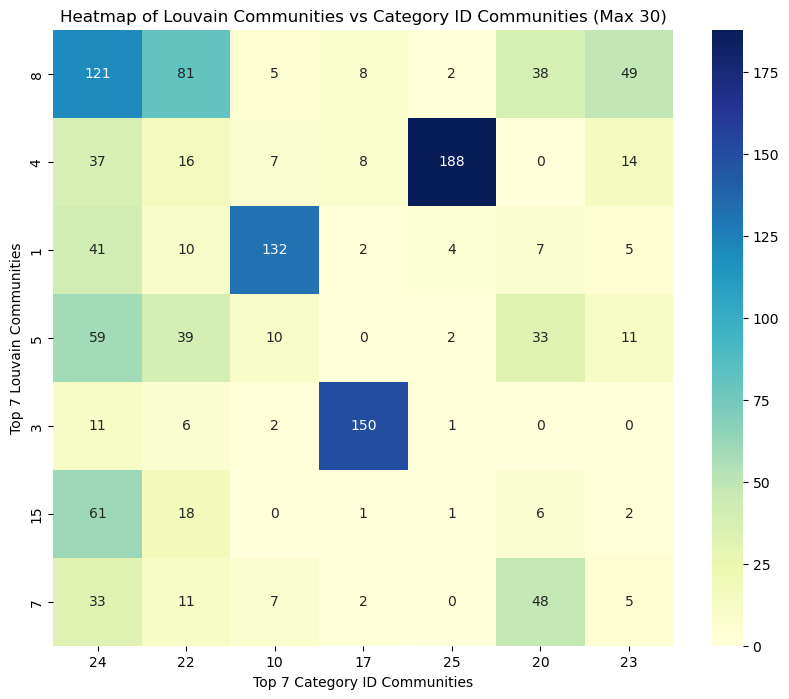

In [78]:
# Identify the top 7 Louvain communities in the merged partition
community_counts = Counter(final_partition.values())
top_louvain_communities = [community for community, _ in community_counts.most_common(7)]

# Identify the top 7 Category ID communities
category_counts = Counter(category_partition.values())
top_category_communities = [category for category, _ in category_counts.most_common(7)]

# Initialize confusion matrix
D = np.zeros((7, 7), dtype=int)

# Map Louvain communities and Category ID communities to indices in the matrix
louvain_index = {community: idx for idx, community in enumerate(top_louvain_communities)}
category_index = {category: idx for idx, category in enumerate(top_category_communities)}

# Populate the confusion matrix using the merged partition
for node, louvain_community in final_partition.items():
    category_community = category_partition.get(node)
    
    # Only consider nodes in the top 7 Louvain and top 7 Category communities
    if louvain_community in top_louvain_communities and category_community in top_category_communities:
        i = louvain_index[louvain_community]
        j = category_index[category_community]
        D[i, j] += 1

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(D, annot=True, fmt="d", cmap="YlGnBu",
                 xticklabels=top_category_communities, yticklabels=top_louvain_communities)
ax.set_xlabel("Top 7 Category ID Communities")
ax.set_ylabel("Top 7 Louvain Communities")
ax.set_title("Heatmap of Louvain Communities vs Category ID Communities (Max 30)")
plt.show()


### Visualising the node distributions in the communities to see how evenly distributed the nodes are over the communities:

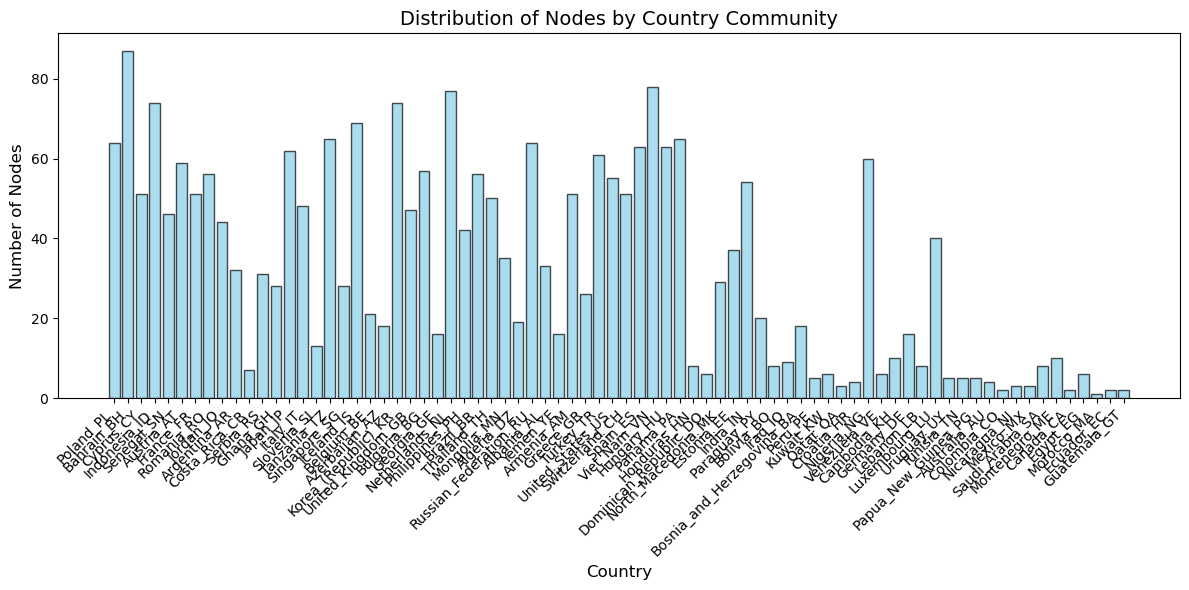

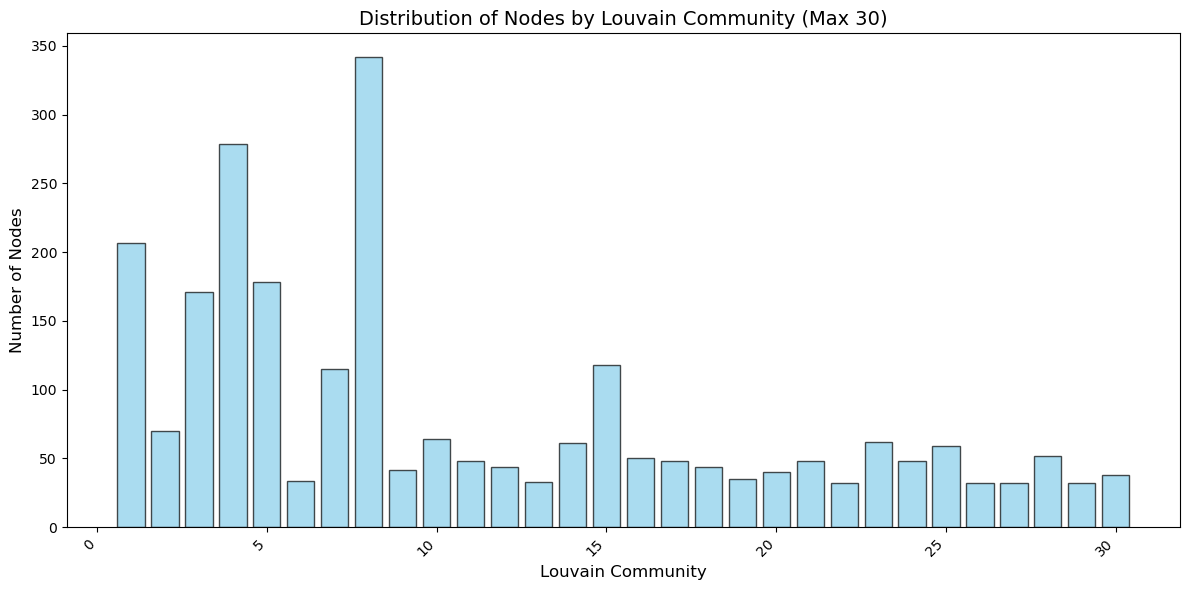

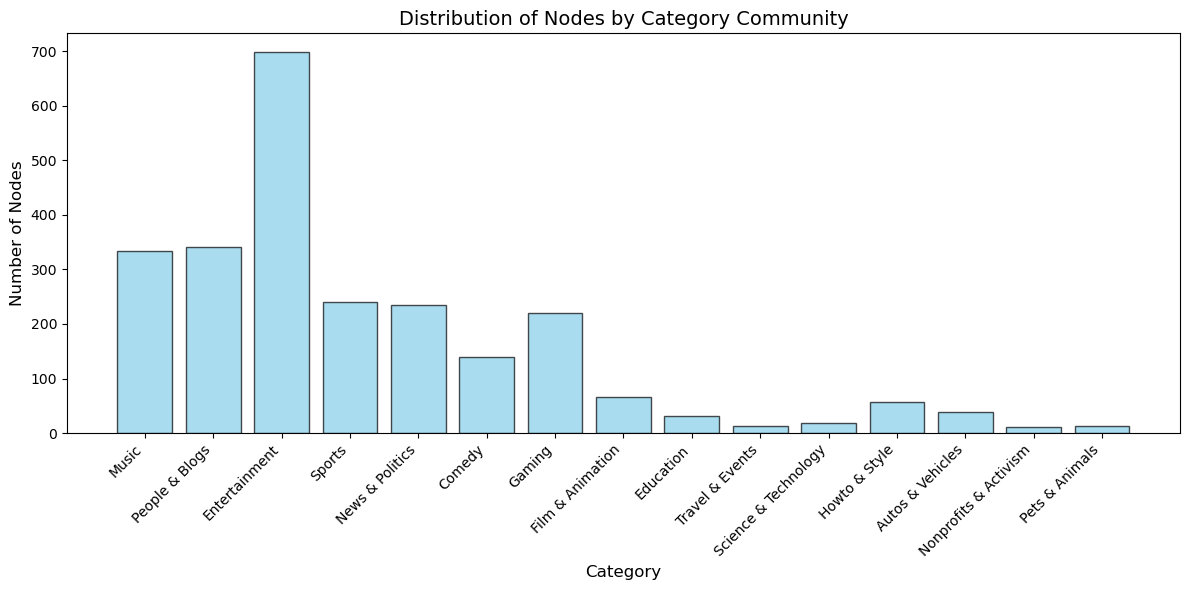

In [79]:
# Define category mapping (if not already defined)
category_mapping = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 18: "Short Movies",
    19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs", 23: "Comedy", 24: "Entertainment",
    25: "News & Politics", 26: "Howto & Style", 27: "Education", 28: "Science & Technology", 29: "Nonprofits & Activism",
    30: "Movies", 31: "Anime/Animation", 32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary",
    36: "Drama", 37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
    43: "Shows", 44: "Trailers"
}

# Function to plot distribution
def plot_distribution(partition, title, xlabel, mapping=None):
    """
    Plot the distribution of nodes across communities or categories.

    Args:
        partition (dict): A dictionary mapping nodes to their community/category.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        mapping (dict): Optional mapping of community/category IDs to names.
    """
    # Count the number of nodes in each community
    community_counts = Counter(partition.values())
    
    # Prepare data for plotting
    communities, counts = zip(*community_counts.items())
    
    # Map communities to names if a mapping is provided
    if mapping:
        communities = [mapping[int(comm)] if int(comm) in mapping else f"Community {comm}" for comm in communities]
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(communities, counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size for readability
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Number of Nodes", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot distributions for each community type

# Plot distribution for country communities
plot_distribution(
    country_partition,
    title="Distribution of Nodes by Country Community",
    xlabel="Country"
)

# Plot distribution for Louvain communities (merged, max 30)
plot_distribution(
    final_partition,  # Use the merged Louvain partition
    title="Distribution of Nodes by Louvain Community (Max 30)",
    xlabel="Louvain Community"
)

# Plot distribution for category communities
plot_distribution(
    category_partition,
    title="Distribution of Nodes by Category Community",
    xlabel="Category",
    mapping=category_mapping  # Pass the category mapping for labeling
)


Figure 4: Node distribution per (1) Country,(2) Louvain Community and (3) CategoryID. As observed in the bar graphs there is an apparent disparity in the division of nodes among communities. This provides some insight on the most popular categories, most active country based creators and louvain communities.

### Visualizing the network based on the different communities, only visualizing the 20 largest louvain-communities:

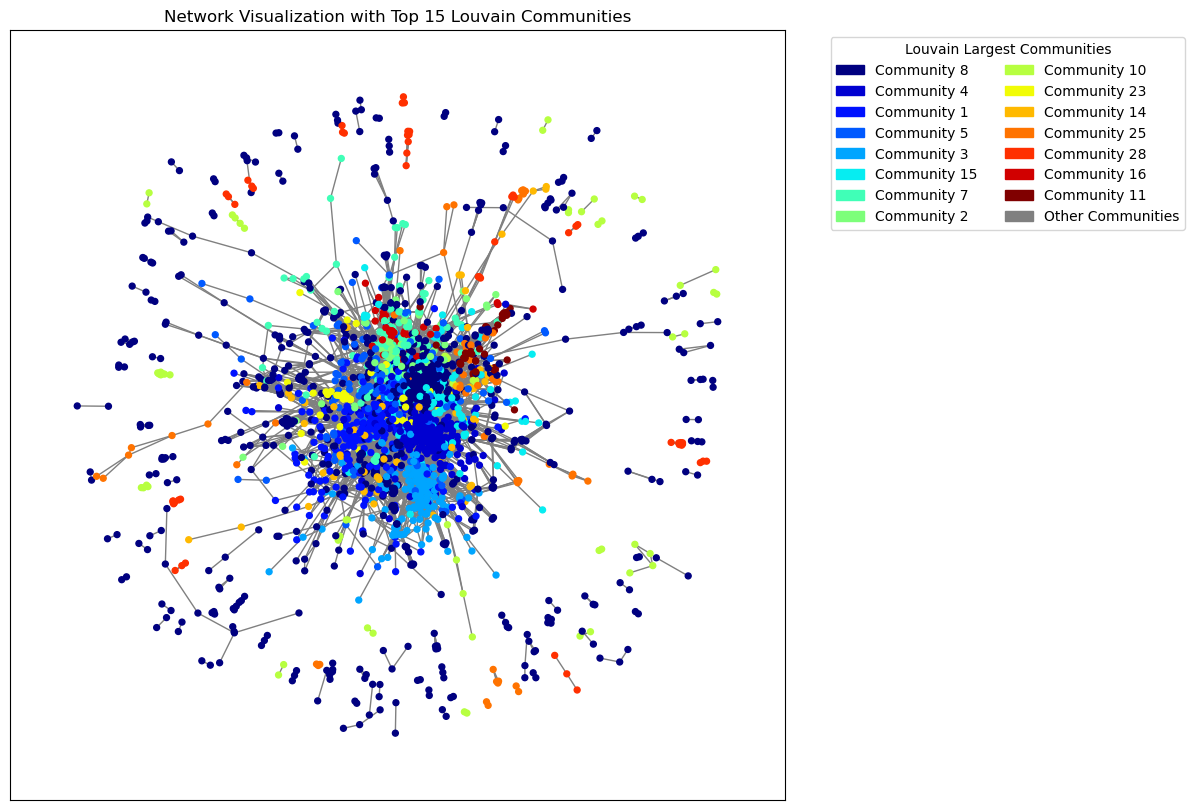

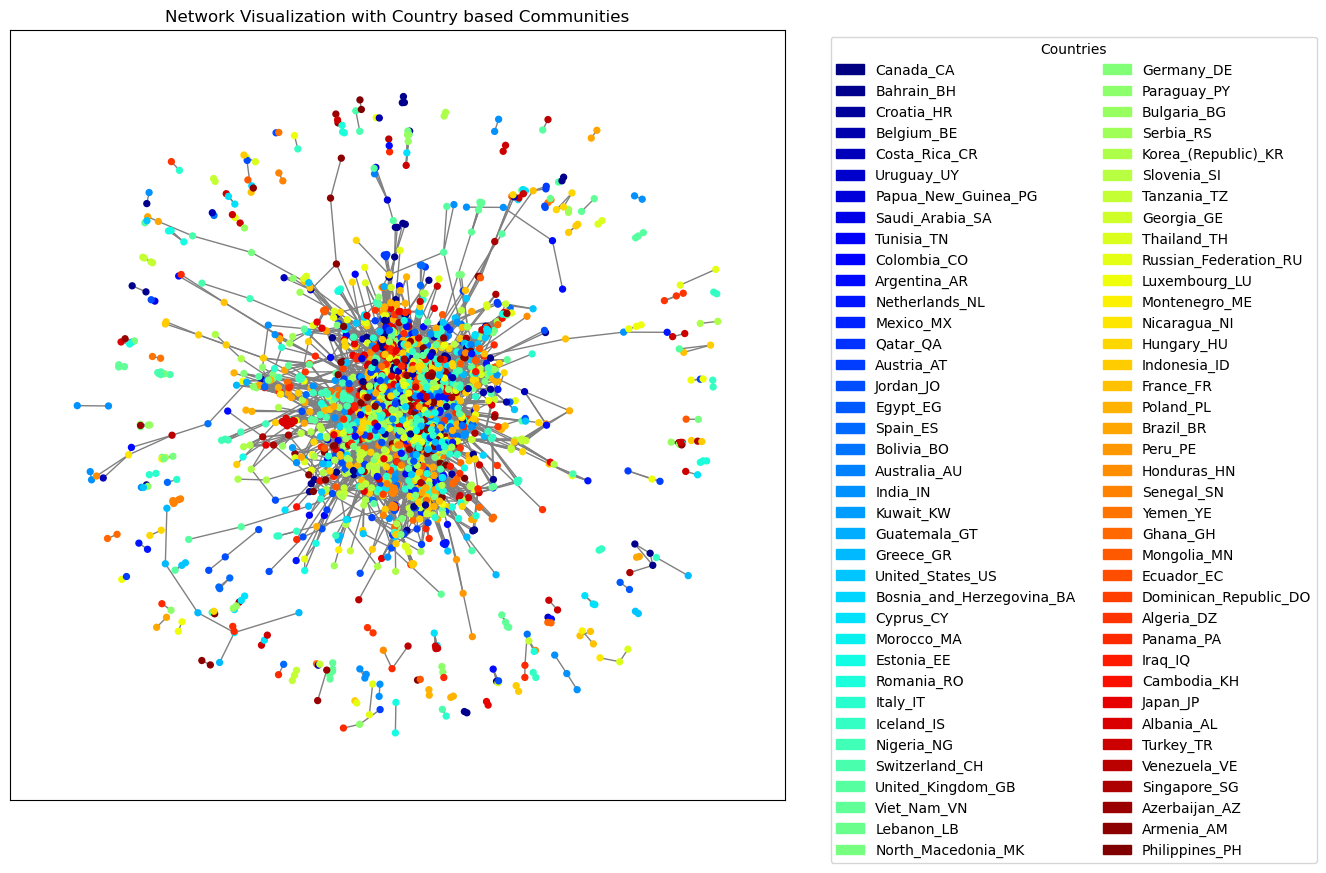

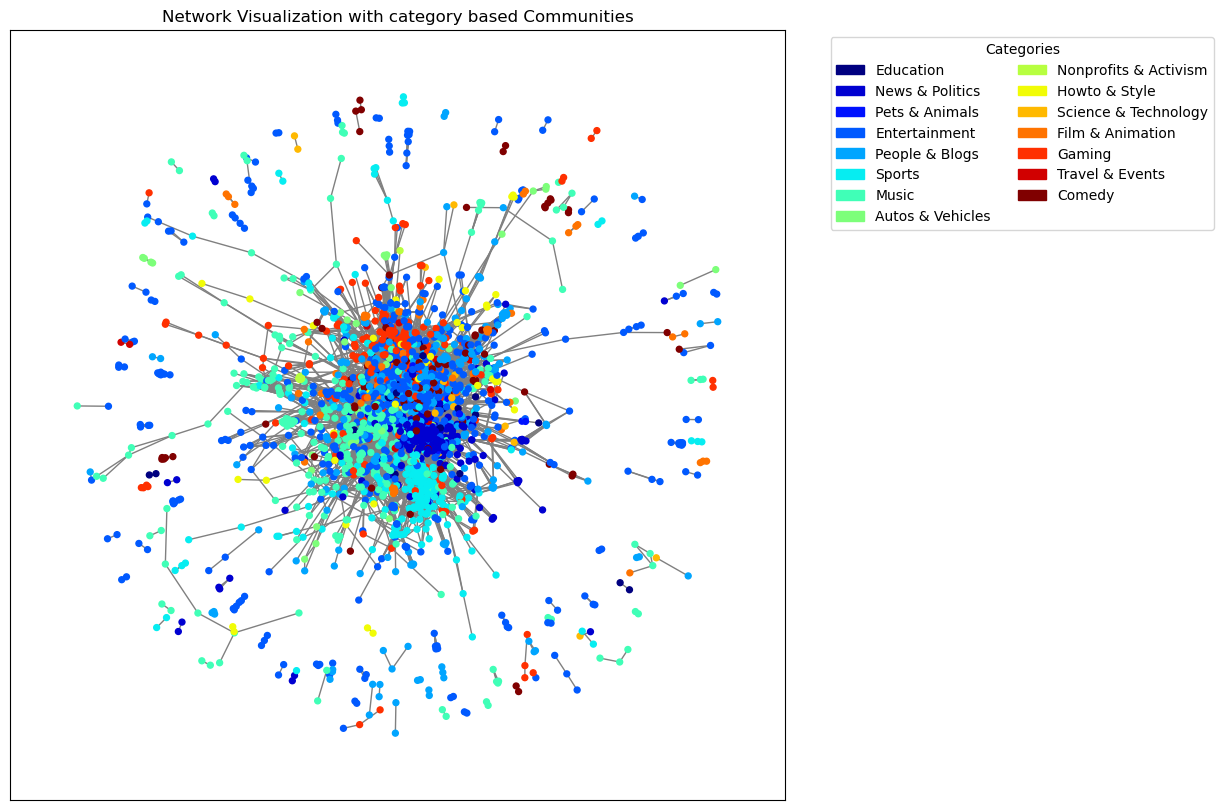

In [140]:
def visualize_network_with_communities(G, partition_type, plot_title, legend_title):
    # Visualizing the network using Force Atlas or Spring Layout
    pos = nx.spring_layout(G, seed=42)

    # Determine unique communities
    unique_communities = set(partition_type.values())

    if partition_type == final_partition:
        # Calculate sizes of the communities
        community_sizes = Counter(partition_type.values())
        # Identify the 10 largest communities
        largest_communities = [community for community, size in community_sizes.most_common(15)]
        
        # Map each community in the top 10 to an index, and others to -1
        community_color_map = {community: idx for idx, community in enumerate(largest_communities)}
        node_community_values = [
            community_color_map.get(partition_type[node], -1) for node in G.nodes
        ]
        norm = Normalize(vmin=0, vmax=len(largest_communities) - 1)  # Use largest_communities
    else:
        # For other partitions, use all unique communities
        community_color_map = {community: idx for idx, community in enumerate(unique_communities)}
        node_community_values = [
            community_color_map[partition_type[node]] for node in G.nodes
        ]
        norm = Normalize(vmin=0, vmax=len(unique_communities) - 1)  # Use unique_communities

    # Define colormap
    cmap = plt.cm.jet

    # Drawing the network
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(
        G, pos,
        node_color=node_community_values,  # Provide numeric values for colormap
        cmap=cmap,
        with_labels=False,
        node_size=18,
        edge_color="gray",
        vmin=0, vmax=norm.vmax
    )

    # Create legend for the top communities
    if partition_type == category_partition:
        category_mapping = {
            1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music", 15: "Pets & Animals", 17: "Sports", 
            18: "Short Movies", 19: "Travel & Events", 20: "Gaming", 21: "Videoblogging", 22: "People & Blogs",
            23: "Comedy", 24: "Entertainment", 25: "News & Politics", 26: "Howto & Style", 27: "Education",
            28: "Science & Technology", 29: "Nonprofits & Activism", 30: "Movies", 31: "Anime/Animation",
            32: "Action/Adventure", 33: "Classics", 34: "Comedy", 35: "Documentary", 36: "Drama", 
            37: "Family", 38: "Foreign", 39: "Horror", 40: "Sci-Fi/Fantasy", 41: "Thriller", 42: "Shorts",
            43: "Shows", 44: "Trailers"
        }

        legend_handles = [
            mpatches.Patch(
                color=cmap(norm(idx)), 
                label=f"{category_mapping.get(int(community), f'Unknown ({community})')}"
            )
            for community, idx in community_color_map.items() if idx != -1
        ]
    elif partition_type == country_partition:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(idx)), label=f"{community}")
            for community, idx in community_color_map.items() if idx != -1
        ]
    elif partition_type == final_partition:
        legend_handles = [
            mpatches.Patch(color=cmap(norm(idx)), label=f"Community {community}")
            for community, idx in community_color_map.items() if idx != -1
        ]
        # Add legend for greyed-out nodes only for Louvain
        legend_handles.append(mpatches.Patch(color="grey", label="Other Communities"))

    plt.legend(
        handles=legend_handles,
        title=legend_title,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        ncol=2
    )
    plt.title(plot_title)
    plt.show()

# Update inputs to use final_partition
inputs = [
    {"partition_type": final_partition, "plot_title": "Network Visualization with Top 15 Louvain Communities", "legend_title": "Louvain Largest Communities"},
    {"partition_type": country_partition, "plot_title": "Network Visualization with Country based Communities", "legend_title": "Countries"},
    {"partition_type": category_partition, "plot_title": "Network Visualization with category based Communities", "legend_title": "Categories"}
]

# Loop through the inputs and visualize
for input_data in inputs:
    visualize_network_with_communities(
        G=G,
        partition_type=input_data["partition_type"],
        plot_title=input_data["plot_title"],
        legend_title=input_data["legend_title"]
    )


Figure 5: Network visualizations based on (1) Louvain Communities, (2) Country Communities and (3) Category based Communities. We observe that both the Louvain and CategoryID based communities showcase apparent connected clusters forming which belong to the same community. As for country based communiteis the nodes belonging to a certain country are scattered all over the graph which reinforces the low modularity and weak community structure.

## Part 3: Further network analysis

### Measuring closeness centrality, eigenvector centrality, betweeness centrality and degree centrality

- Closeness Centrality measures how close a node is to all other nodes in the graph.
- Eigenvector Centrality measures the influence of a node based on the importance of its neighbors.
- Betweenness Centrality measures how often a node acts as a bridge along the shortest path between two other nodes.
- Degree Centrality the number of edges connected to a node.


In [84]:
translator = GoogleTranslator()

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Get the most central nodes based on degree centrality
most_central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)

# Print titles of the most central nodes
print("Most central 5 nodes by degree centrality:")
for node in most_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Get the most central nodes based on betweenness centrality
most_between_central_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)

# Print titles of the most between-central nodes
print("\nMost central 5 nodes by betweenness centrality:")
for node in most_between_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")


eigenvector_centrality = nx.eigenvector_centrality(G)
most_eigenvector_central_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)
print("\nMost central 5 nodes by eigenvector centrality:")
for node in most_eigenvector_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")


closeness_centrality = nx.closeness_centrality(G)
most_closeness_central_nodes = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)
print("\nMost central 5 nodes by closeness centrality:")
for node in most_closeness_central_nodes[:5]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    country = G.nodes[node].get('country', 'No country')
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Title: {translated_title}, Country: {country}")



Most central 5 nodes by degree centrality:
Title: Sharing chopsticks and spoon #shorts, Country: ['Viet_Nam_VN']
Title: Believe everything people say #shorts, Country: ['Viet_Nam_VN']
Title: THE NEW GIRL | Season 2 (FINALE), Episode 9 | Yawaskits, Country: ['Nigeria_NG']
Title: Try not to laugh Game!!!, Country: ['Romania_RO', 'Poland_PL']
Title: The King Copycats Of YouTube, Country: ['Iceland_IS', 'Estonia_EE']

Most central 5 nodes by betweenness centrality:
Title: FIFI - JETA JEM (Magic Song 2024) #musicistheanswer, Country: ['Albania_AL']
Title: I DON'T BELIEVE IT 🤯 TRUMP was elected after having..., Country: ['Italy_IT']
Title: Hiding in Secret Room to Prank My Dad *Security Cameras*, Country: ['Estonia_EE']
Title: I Met Messi, Country: ['Bolivia_BO', 'Colombia_CO', 'Honduras_HN', 'Ecuador_EC', 'Paraguay_PY', 'Guatemala_GT', 'Mexico_MX', 'Dominican_Republic_DO']
Title: Trump will be president again! And now? | #analysis, Country: ['Austria_AT', 'Switzerland_CH', 'Germany_DE', 'Lu

ADD: Describe output

### Calculating assortivity based on degrees and categories

Assortativity is a measure of the tendency of nodes in a graph to connect to other nodes that share similar properties, such as degree, attributes, or other nodal characteristics.

In [9]:
degrees = dict(G.degree())

# assortivity based on node degrees
degree_pairs = [(degrees[u], degrees[v]) for u, v in G.edges()]
degree_a, degree_b = zip(*degree_pairs)
assortativity_coefficient, _ = pearsonr(degree_a, degree_b)
print("Assortativity Coefficient based on node degrees:", assortativity_coefficient)

# Calculate assortativity based on the 'categoryID' attribute
category_assortativity = nx.attribute_assortativity_coefficient(G, 'categoryId')
print(f"Assortativity coefficient based on 'categoryID': {category_assortativity}")


Assortativity Coefficient based on node degrees: 0.4071948369121694
Assortativity coefficient based on 'categoryID': 0.3390450204085398


ADD: description of what this tells us

In [14]:

country_counts = {}

# Iterate through each node and its data in the graph
for node, data in G.nodes(data=True):
    # Check if 'country' attribute exists and is a list
    if 'country' in data and isinstance(data['country'], list):
        # Store the number of countries for each node
        country_counts[node] = len(data['country'])

# Sort the nodes based on the count of countries, in descending order
sorted_country_counts = sorted(country_counts.items(), key=lambda item: item[1], reverse=True)

print("Top videos in largest amount of countries:")
# Print the top 10 nodes and their country counts
for node, count in sorted_country_counts[:10]:
    title = G.nodes[node].get('title', 'No Title')  # Get the 'title' attribute or default to 'No Title'
    translated_title = translator.translate(title, source='auto', target='en')
    print(f"Video: {translated_title}, Number of countries: {count}")


Top videos in largest amount of countries:
Video: Angel Edgar VS Demon Mortis - Animation, Number of countries: 52
Video: DEMONS ARE ATTACKING BRAWL STARS!!!, Number of countries: 48
Video: BABYMONSTER - 'DRIP' M/V, Number of countries: 45
Video: ROSÉ & Bruno Mars - APT. (Official Music Video), Number of countries: 40
Video: My Daughter's Emotional 15th BIRTHDAY SURPRISE, Number of countries: 33
Video: 진 (Jin) 'I'll Be There' Official MV, Number of countries: 31
Video: HYPERCHARGE FOR WATCHING THE BRAWL STARS WORLD FINALS?! 🥵, Number of countries: 31
Video: HIGHLIGHTS Sporting CP 4-1 Man City | Foden, Gyorkeres hat-trick & Araujo goals, Number of countries: 31
Video: The IMPOSSIBLE Puzzle.., Number of countries: 30
Video: Donald Trump speaks after winning the 2024 Presidential Election, Number of countries: 29


## Part 4: Sentiment analysis

### Determining TF-IDF scores for comments across largest Louvain Communities


Top 10 words for Louvain Community 4 based on TF-IDF:
trump: 492.8362
putin: 313.0303
prabowo: 238.3084
ukrainian: 231.8072
ukraine: 228.3391
biden: 221.2037
duterte: 216.4430
harris: 214.3072
democrat: 213.7033
sawicki: 159.8563

Top 10 words for Louvain Community 8 based on TF-IDF:
lizzie: 207.4730
siowei: 181.4394
feride: 181.4394
hovhannes: 176.8623
tuyet: 156.5758
nobita: 149.6527
nintendo: 145.1325
robleis: 136.0479
deepa: 122.4431
bovi: 112.2395

Top 10 words for Louvain Community 3 based on TF-IDF:
zamalek: 354.7546
liverpool: 317.2526
mbappe: 303.9412
arsenal: 297.3951
marmoush: 282.2994
chivas: 238.0838
madrid: 236.6582
salah: 229.9588
referee: 223.7364
ahli: 205.8118

Top 10 words for Louvain Community 1 based on TF-IDF:
아파트: 330.3821
mirza: 167.8991
emily: 141.4279
jake: 129.5321
jenna: 127.2784
yejun: 119.0419
emilia: 116.4644
laufey: 112.2395
miyu: 105.6140
tyson: 100.4534

Top 10 words for Louvain Community 5 based on TF-IDF:
ㅋㅋㅋ: 292.9316
kimchi: 287.8231
sherine: 262.

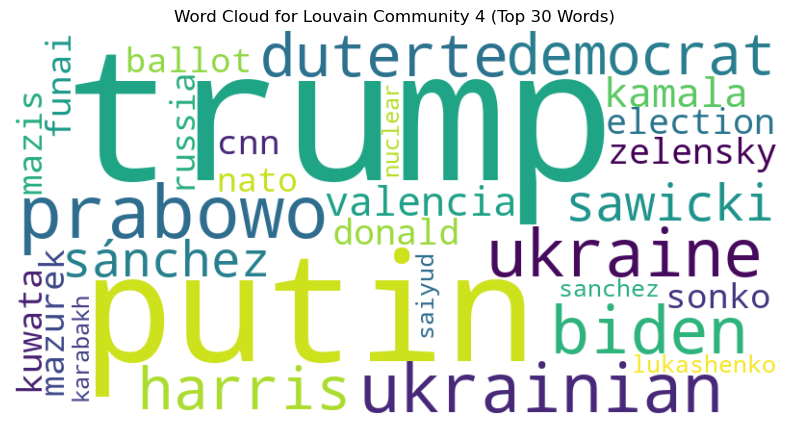

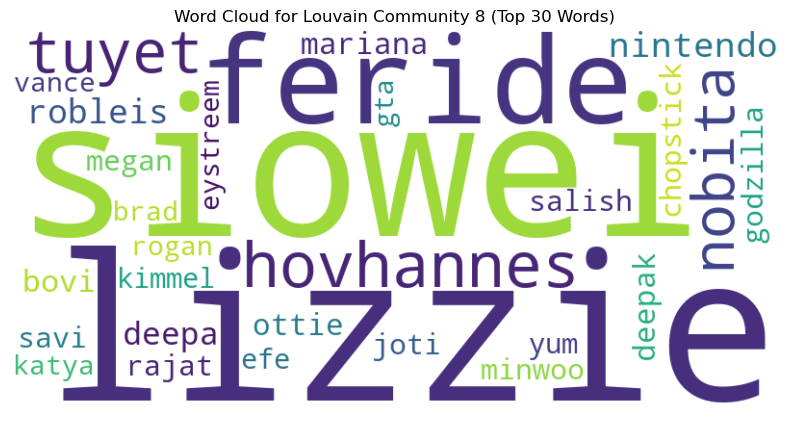

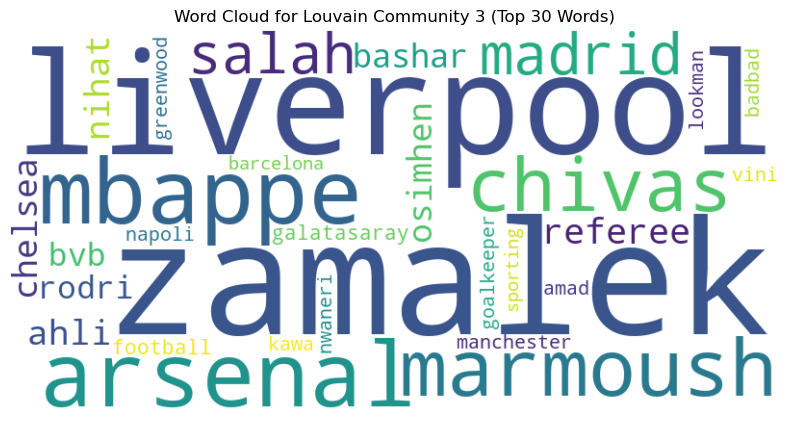

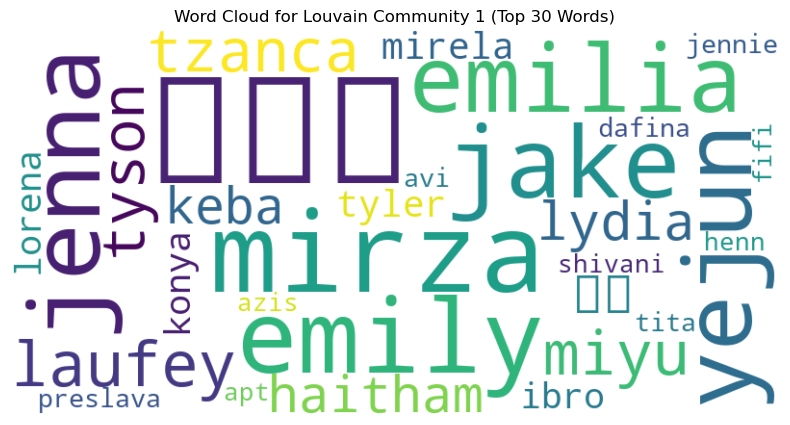

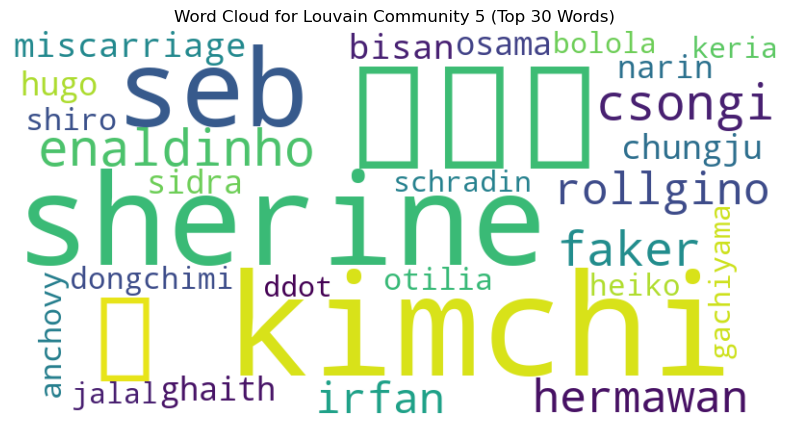

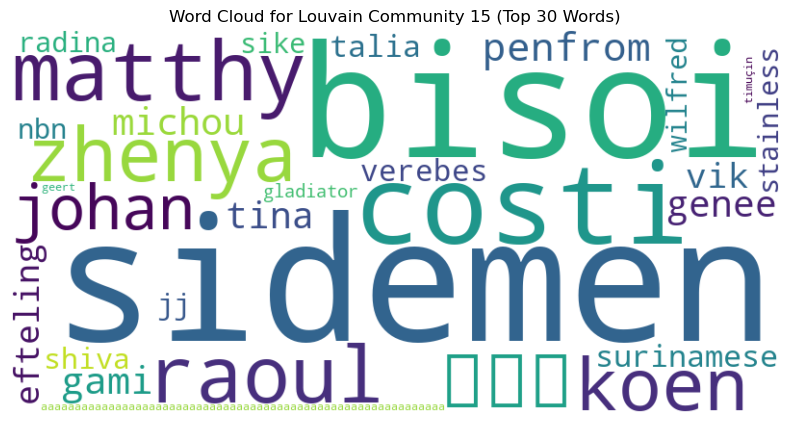

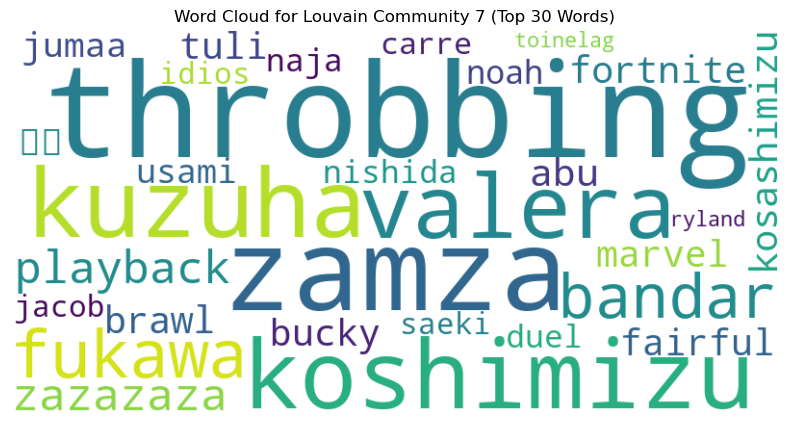

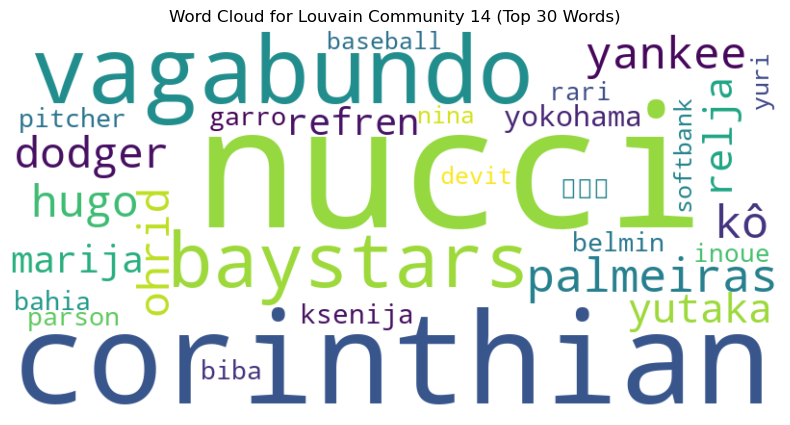

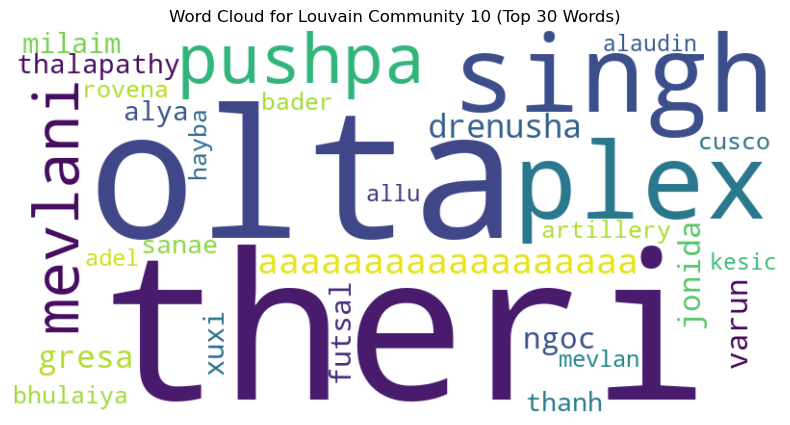

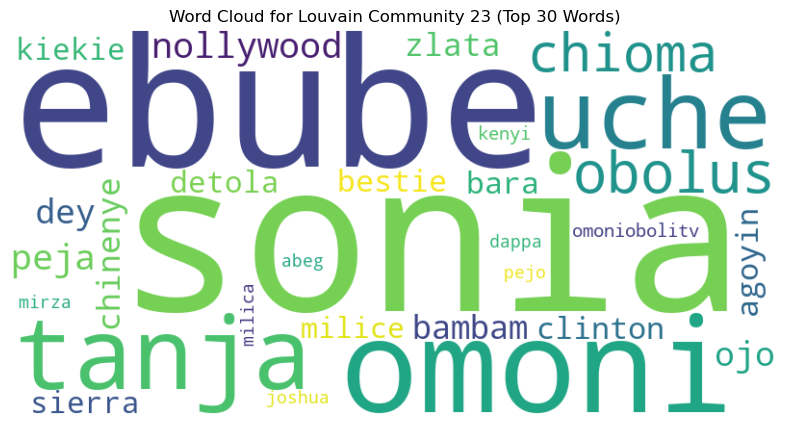

In [90]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def process_text(text):
    """Tokenize, lemmatize, and remove stopwords from the input text."""
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in tokens if token not in stop_words]

# Aggregate comments by communities in `final_partition`
def aggregate_comments_by_community(graph, partition):
    """Aggregate comments for each community from node attributes."""
    community_comments = defaultdict(list)
    for node, community in partition.items():
        comments = graph.nodes[node].get('comments', '')
        if comments:
            community_comments[community].extend(process_text(comments))
    return community_comments

# Aggregating comments by Louvain communities
community_comments = aggregate_comments_by_community(G, final_partition)

# Calculate term frequencies (TF) for each community
community_term_frequencies = {community: Counter(tokens) for community, tokens in community_comments.items()}

# Calculate document frequencies (DF) across all communities
document_frequency = Counter(word for term_freqs in community_term_frequencies.values() for word in term_freqs)

# Calculate Inverse Document Frequency (IDF)
N = len(community_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in document_frequency.items()}

# Calculate TF-IDF scores for each community
community_tfidf_scores = {
    community: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for community, term_freqs in community_term_frequencies.items()
}

# Identify the 10 largest Louvain communities by number of nodes
largest_communities = sorted(
    community_comments.keys(), 
    key=lambda community: len(community_comments[community]), 
    reverse=True
)[:10]

# Print the top 10 words by TF-IDF for the largest 10 communities
for community in largest_communities:
    top_words = sorted(community_tfidf_scores[community].items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 words for Louvain Community {community} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

# Generate and save word clouds for the largest 10 communities with top 30 words
def generate_wordclouds(community_tfidf_scores, largest_communities, output_folder, top_n=30):
    """Generate and save word clouds for the largest communities based on TF-IDF scores."""
    os.makedirs(output_folder, exist_ok=True)
    for community in largest_communities:
        scores = community_tfidf_scores[community]
        if scores:
            # Limit the word cloud to the top N words
            top_words = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n])
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
            wordcloud.to_file(os.path.join(output_folder, f"community_{community}_wordcloud.png"))
            
            # Optionally display the word cloud
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud for Louvain Community {community} (Top {top_n} Words)")
            plt.show()

# Generating word clouds for the 10 largest Louvain communities
generate_wordclouds(community_tfidf_scores, largest_communities, 'tfidf_wordclouds_Louvain', top_n=30)


ADD: Description of output

### Determining TF-IDF scores for comments across country partition

In [92]:
# Aggregate comments by country from the graph
def aggregate_comments_by_country(graph):
    """Aggregate comments for each country from node attributes."""
    country_comments = defaultdict(list)
    for node, data in graph.nodes(data=True):
        countries = data.get('country', [])  # Always a list
        comments = data.get('comments', '')
        if comments:
            for country in countries:  # Iterate through each country
                country_comments[country].extend(process_text(comments))
    return country_comments

# Aggregate comments by country
country_comments = aggregate_comments_by_country(G)

# Calculate term frequencies (TF) for each country
country_term_frequencies = {country: Counter(tokens) for country, tokens in country_comments.items()}

# Calculate document frequencies (DF) across countries
country_document_frequency = Counter(word for term_freqs in country_term_frequencies.values() for word in term_freqs)

# Calculate Inverse Document Frequency (IDF)
N = len(country_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in country_document_frequency.items()}

# Calculate TF-IDF scores for each country
country_tfidf_scores = {
    country: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for country, term_freqs in country_term_frequencies.items()
}

# Print the top 10 words by TF-IDF for each country
top_words_by_country_tfidf = {
    country: sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
    for country, scores in country_tfidf_scores.items()
}

for country, top_words in top_words_by_country_tfidf.items():
    print(f"\nTop 10 words for Country: {country} based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

# # Generate and save word clouds for all countries with top 30 words
# def generate_country_wordclouds(country_tfidf_scores, output_folder, top_n=30):
#     """Generate and save word clouds for each country based on TF-IDF scores."""
#     os.makedirs(output_folder, exist_ok=True)
#     for country, scores in country_tfidf_scores.items():
#         if scores:
#             # Limit the word cloud to the top N words
#             top_words = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n])
#             wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
#             wordcloud.to_file(os.path.join(output_folder, f"country_{country}_wordcloud.png"))
            
#             # Optionally display the word cloud
#             plt.figure(figsize=(10, 5))
#             plt.imshow(wordcloud, interpolation='bilinear')
#             plt.axis("off")
#             plt.title(f"Word Cloud for Country {country} (Top {top_n} Words)")
#             plt.show()

# # Generate word clouds for all countries
# print("Generating word clouds for all countries...")
# generate_country_wordclouds(country_tfidf_scores, 'tfidf_wordclouds_Country', top_n=30)



Top 10 words for Country: Poland_PL based on TF-IDF:
sawicki: 205.9553
genzie: 205.9553
polish: 205.8793
shalt: 197.0049
douglas: 195.5106
przemek: 184.0451
poland: 173.4546
tusk: 170.7375
mazurek: 166.5170
warsaw: 158.6218

Top 10 words for Country: Bahrain_BH based on TF-IDF:
israa: 222.6389
abu: 199.6514
sherine: 179.1155
singh: 158.0063
allah: 157.6235
sesame: 122.3157
bashar: 118.8523
bandar: 110.4824
omar: 103.9324
ghaith: 82.0248

Top 10 words for Country: Jordan_JO based on TF-IDF:
gigi: 408.7311
rania: 382.2291
israa: 222.6389
sherine: 154.0058
ahli: 115.7243
zamalek: 94.1203
abu: 85.7293
yahya: 79.7781
adel: 77.4407
allah: 74.2356

Top 10 words for Country: Yemen_YE based on TF-IDF:
israa: 222.6389
sherine: 195.8552
allah: 121.6922
abu: 119.1004
bashar: 113.8304
bandar: 108.8085
marmoush: 93.2496
ghaith: 83.6988
sesame: 83.5327
nour: 78.7500

Top 10 words for Country: Algeria_DZ based on TF-IDF:
rania: 276.3102
gigi: 265.8736
algerian: 136.4254
sherine: 103.7865
algeria: 98.

ADD: Description of output

### Determining TF-IDF scores for comments across Category ID partition


Top 10 words for Category: Entertainment (ID: 24) based on TF-IDF:
ruhi: 372.7571
salish: 360.6676
abhira: 333.0902
leyla: 328.4292
nidal: 287.0533
fede: 252.6808
nur: 239.8062
jordanmatter: 216.6440
movie: 214.9375
chilsungsa: 211.2279

Top 10 words for Category: News & Politics (ID: 25) based on TF-IDF:
trump: 303.9215
duterte: 193.4307
sonko: 149.3584
akua: 143.5267
prabowo: 136.8022
monarchy: 134.9985
sawicki: 127.2784
sanchez: 120.2798
democrat: 117.5498
donkor: 113.7381

Top 10 words for Category: People & Blogs (ID: 22) based on TF-IDF:
asbel: 1161.7535
slime: 388.5073
israa: 296.1907
ろ: 178.7313
emily: 158.6107
copito: 151.6508
hovhannes: 140.8186
zhenya: 126.9389
emilia: 120.2798
clik: 119.1542

Top 10 words for Category: Music (ID: 10) based on TF-IDF:
healthys: 1825.2258
nucci: 335.7982
song: 329.0960
아파트: 245.8182
album: 200.5262
arashi: 184.1474
bake: 175.7780
lyric: 172.6591
ifraimova: 157.0669
amadeus: 151.6508

Top 10 words for Category: Sports (ID: 17) based on TF-IDF

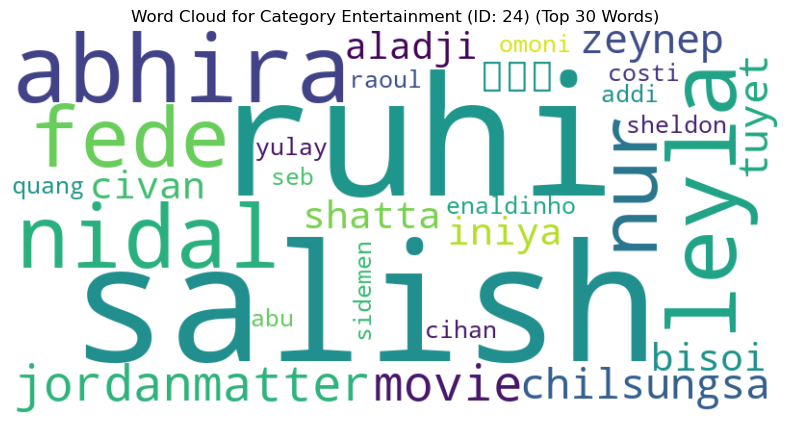

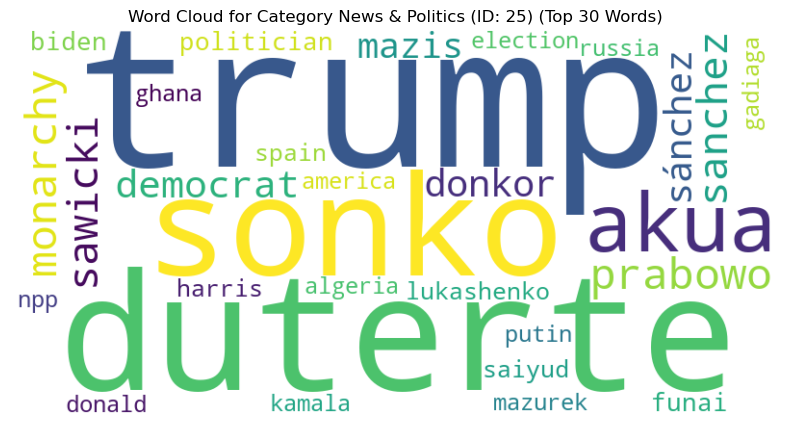

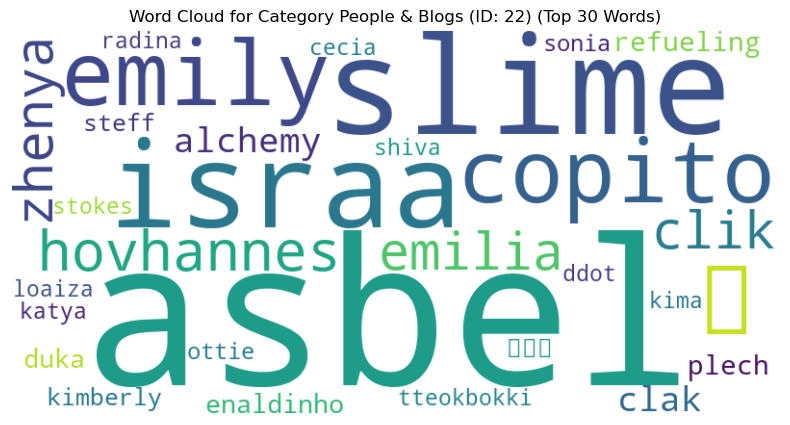

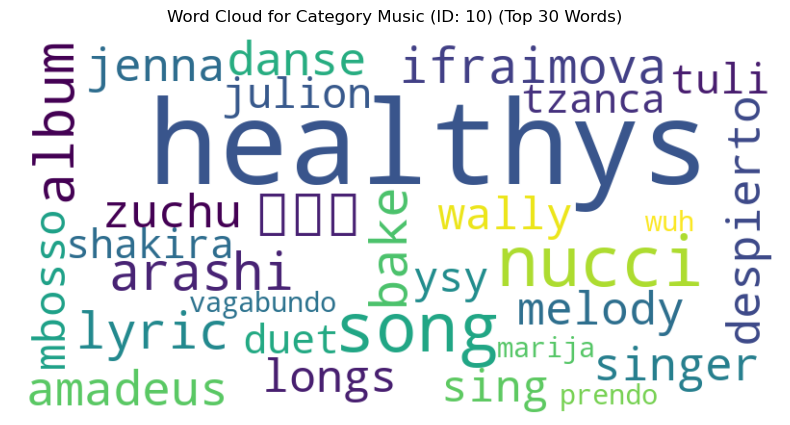

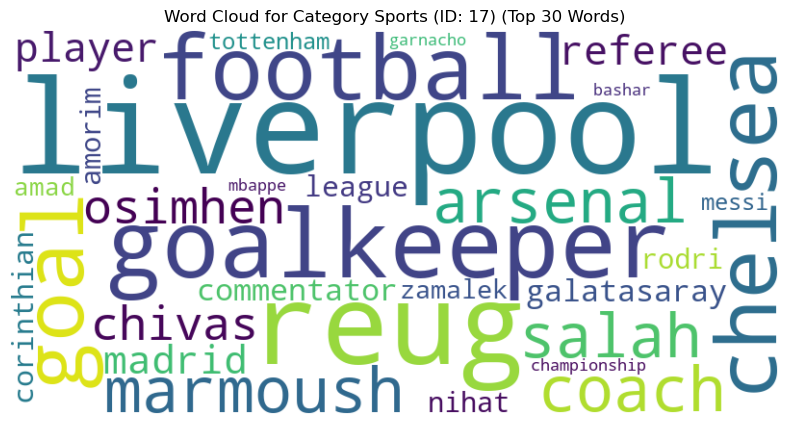

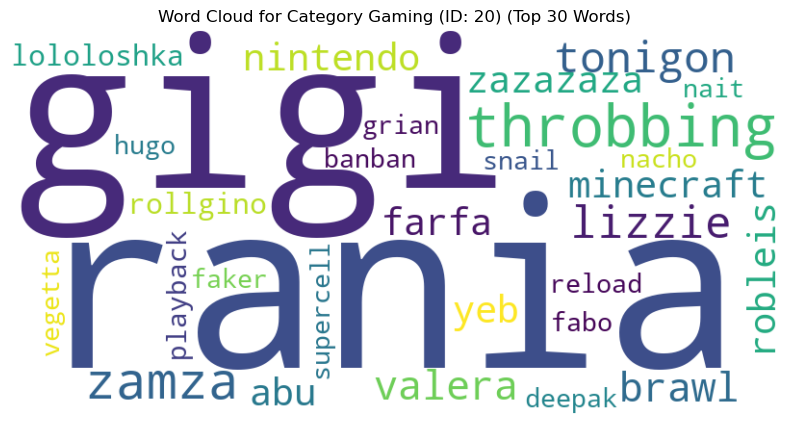

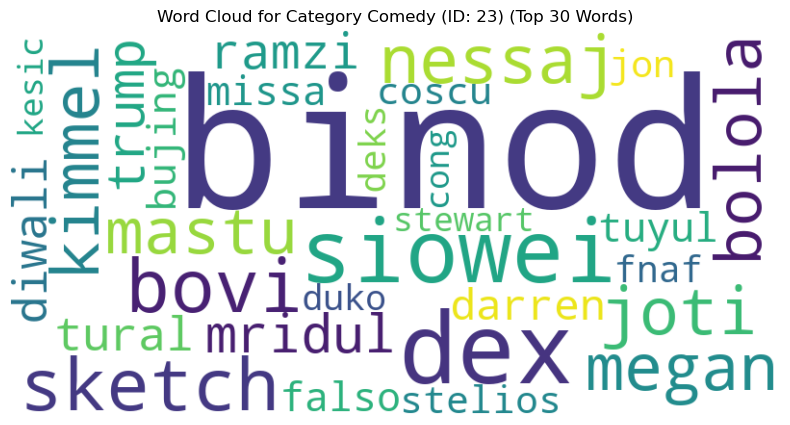

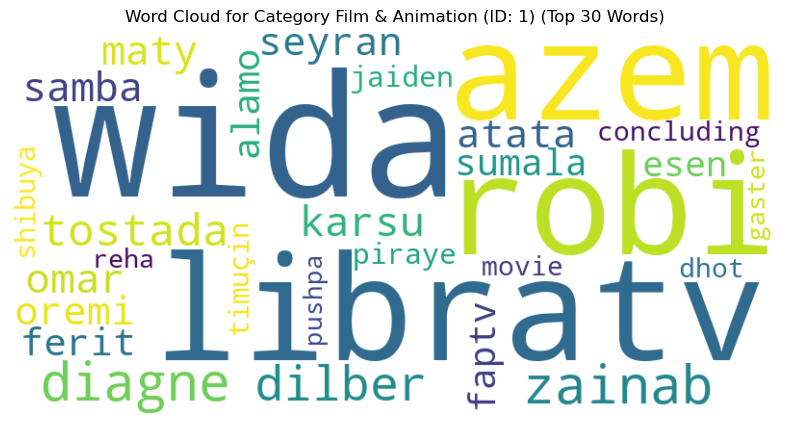

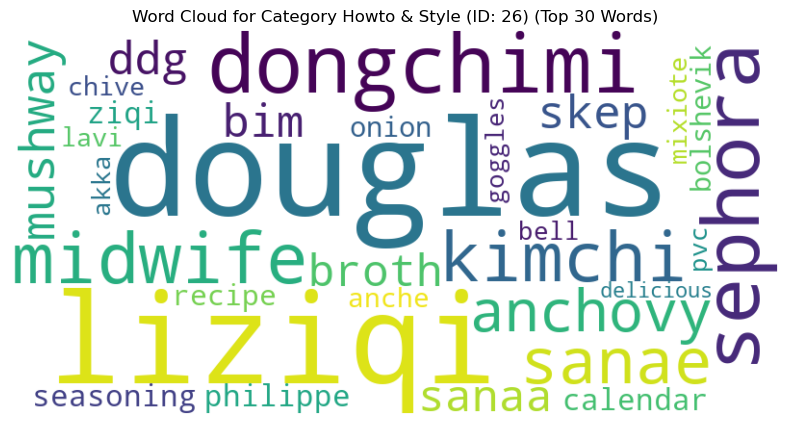

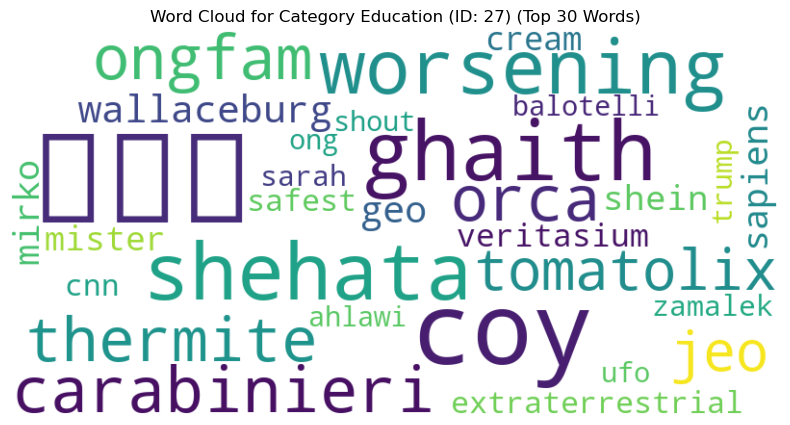

In [94]:
# Aggregate comments by categoryId from the graph
def aggregate_comments_by_category(graph):
    """Aggregate comments for each category ID from node attributes."""
    category_comments = defaultdict(list)
    for node, data in graph.nodes(data=True):
        category_id = data.get('categoryId')  # 'categoryId' is a single value
        comments = data.get('comments', '')
        if category_id and comments:
            category_comments[category_id].extend(process_text(comments))
    return category_comments

# Aggregate comments by category
category_comments = aggregate_comments_by_category(G)

# Calculate term frequencies (TF) for each category
category_term_frequencies = {category: Counter(tokens) for category, tokens in category_comments.items()}

# Calculate document frequencies (DF) across categories
category_document_frequency = Counter(word for term_freqs in category_term_frequencies.values() for word in term_freqs)

# Calculate Inverse Document Frequency (IDF)
N = len(category_term_frequencies)
idf_values = {word: math.log(N / df) for word, df in category_document_frequency.items()}

# Calculate TF-IDF scores for each category
category_tfidf_scores = {
    category: {word: tf * idf_values[word] for word, tf in term_freqs.items()}
    for category, term_freqs in category_term_frequencies.items()
}

# Identify the 10 largest categories by number of comments
largest_categories = sorted(
    category_comments.keys(),
    key=lambda category: len(category_comments[category]),
    reverse=True
)[:10]

# Print the top 10 words by TF-IDF for the largest 10 categories
top_words_by_category_tfidf = {
    category: sorted(category_tfidf_scores[category].items(), key=lambda x: x[1], reverse=True)[:10]
    for category in largest_categories
}

for category, top_words in top_words_by_category_tfidf.items():
    category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
    print(f"\nTop 10 words for Category: {category_name} (ID: {category}) based on TF-IDF:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

# Generate and save word clouds for the largest 10 categories with top 30 words
def generate_category_wordclouds(category_tfidf_scores, largest_categories, output_folder, top_n=30):
    """Generate and save word clouds for the largest categories based on TF-IDF scores."""
    os.makedirs(output_folder, exist_ok=True)
    for category in largest_categories:
        scores = category_tfidf_scores[category]
        if scores:
            # Limit the word cloud to the top N words
            top_words = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n])
            category_name = category_mapping.get(int(category), f"Unknown Category ({category})")
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
            wordcloud.to_file(os.path.join(output_folder, f"category_{category}_wordcloud.png"))
            
            # Optionally display the word cloud
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Word Cloud for Category {category_name} (ID: {category}) (Top {top_n} Words)")
            plt.show()

# Generate word clouds for the largest 10 categories
generate_category_wordclouds(category_tfidf_scores, largest_categories, 'tfidf_wordclouds_Category', top_n=30)


ADD: Description of output

### Loading the LabMT word list for the sentiment analysis

In [95]:
# Function to load the LabMT word list from a CSV file and create a dictionary
def load_labmt_word_list(csv_file_path):
    labmt_words = {}

    # Open and read the CSV file
    with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file)  # Use DictReader for column names
        for row in csv_reader:
            word = row['word'].lower()  # Get the word and convert to lowercase
            happiness_score = float(row['happiness_average'])  # Get the happiness score as a float
            labmt_words[word] = happiness_score  # Add word and score to the dictionary
    
    return labmt_words

csv_file_path = 'labMIT.xls'  # Replace with the correct file path
labmt_words_dict = load_labmt_word_list(csv_file_path)

print("LabMT word list loaded.")

LabMT word list loaded.


### Sentiment analysis for all video comments and transcripts:

In [97]:
# Function to calculate sentiment score
def calculate_sentiment(tokens, labmt_words):
    """Calculate the sentiment score for a given list of tokens."""
    sentiment_score = 0
    count = 0
    for token in tokens:
        if token in labmt_words:
            sentiment_score += labmt_words[token]
            count += 1
    return sentiment_score / count if count > 0 else 0

# Function to tokenize text
def process_text(text):
    """Tokenize text into lowercase alphanumeric tokens."""
    return re.findall(r'\b\w+\b', text.lower())

# Iterate over each node in the graph
for node, data in G.nodes(data=True):
    # Extract comments and transcript from node attributes
    comments = data.get('comments', '')
    transcript = data.get('transcript', '')
    
    # Tokenize comments and transcript
    comment_tokens = process_text(comments)
    transcript_tokens = process_text(transcript)
    
    # Calculate sentiment scores
    comment_sentiment = calculate_sentiment(comment_tokens, labmt_words_dict)
    transcript_sentiment = calculate_sentiment(transcript_tokens, labmt_words_dict)
    
    # Compare sentiment scores
    sentiment_comparison = {
        'comments_sentiment': comment_sentiment,
        'transcript_sentiment': transcript_sentiment,
        'difference': abs(comment_sentiment - transcript_sentiment)
    }
    
    # Add sentiment scores as node properties
    G.nodes[node]['sentiment_comparison'] = sentiment_comparison


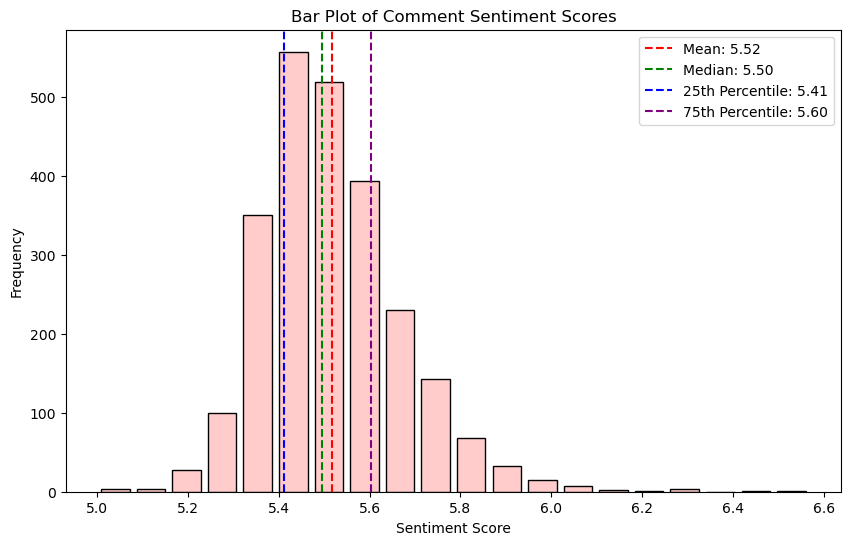

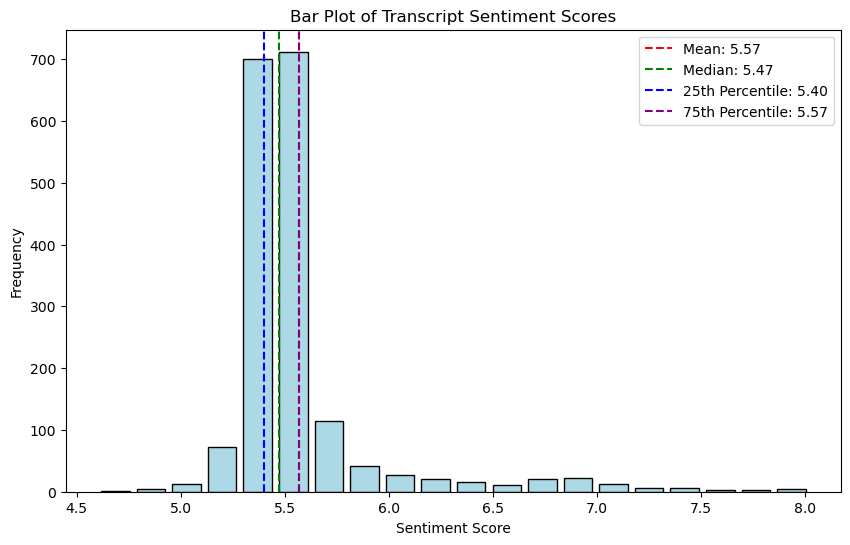


Top 10 Saddest Comments
-----------------------
Title: CHARTTE OF ICE CRINE 🍦 Surprise of the Grandpa T-shirt!
    Sentiment: 5.00
    Country: ['Russian_Federation_RU', 'Georgia_GE']

Title: Keicy vs 20 caleñas
    Sentiment: 5.02
    Country: ['Panama_PA', 'Costa_Rica_CR', 'Bolivia_BO', 'Colombia_CO', 'Honduras_HN', 'Ecuador_EC', 'Guatemala_GT', 'Dominican_Republic_DO']

Title: The one that sets more giant balls wins $ 120,000 - Summer Kamp 2024
    Sentiment: 5.06
    Country: ['Panama_PA', 'Nicaragua_NI']

Title: Robleis juega Fears to Fathom: Woodbury Getaway
    Sentiment: 5.10
    Country: ['Panama_PA', 'Argentina_AR', 'Costa_Rica_CR', 'Bolivia_BO', 'Colombia_CO', 'Honduras_HN', 'Ecuador_EC', 'Paraguay_PY', 'Uruguay_UY', 'Guatemala_GT', 'Peru_PE', 'Venezuela_VE', 'Mexico_MX', 'Dominican_Republic_DO', 'Chile_CL']

Title: The most sharp stone in the world #thuthach
    Sentiment: 5.10
    Country: ['Viet_Nam_VN']

Title: DUKI, Lia Kali - Constlacón (Official Video)
    Sentiment:

In [100]:
# Extract sentiment values for comments and transcripts
def extract_sentiments(graph, sentiment_type):
    """Extract sentiment values from the graph nodes, ignoring None and 0 values."""
    return [
        data['sentiment_comparison'][sentiment_type]
        for _, data in graph.nodes(data=True)
        if data.get('sentiment_comparison', {}).get(sentiment_type) not in (None, 0)
    ]

comment_sentiments = extract_sentiments(G, 'comments_sentiment')
transcript_sentiments = extract_sentiments(G, 'transcript_sentiment')

# Helper function to calculate statistics and plot sentiment distribution
def plot_sentiment_distribution(sentiments, title, color, xlabel='Sentiment Score', ylabel='Frequency'):
    """Plot a bar plot of sentiment scores and annotate statistical measures."""
    # Calculate statistics
    mean_sentiment = np.mean(sentiments)
    median_sentiment = np.median(sentiments)
    percentile_25 = np.percentile(sentiments, 25)
    percentile_75 = np.percentile(sentiments, 75)
    
    # Create bins and frequencies
    num_bins = 20
    frequencies, bin_edges = np.histogram(sentiments, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, frequencies, width=(bin_edges[1] - bin_edges[0]) * 0.8, color=color, edgecolor='black')
    plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_sentiment:.2f}')
    plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_sentiment:.2f}')
    plt.axvline(percentile_25, color='blue', linestyle='dashed', linewidth=1.5, label=f'25th Percentile: {percentile_25:.2f}')
    plt.axvline(percentile_75, color='purple', linestyle='dashed', linewidth=1.5, label=f'75th Percentile: {percentile_75:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot distributions for comments and transcripts
plot_sentiment_distribution(comment_sentiments, title='Bar Plot of Comment Sentiment Scores', color='#ffcccb')
plot_sentiment_distribution(transcript_sentiments, title='Bar Plot of Transcript Sentiment Scores', color='#add8e6')

# Extract and sort sentiment values for happiest and saddest videos
def extract_and_sort_sentiments(graph, sentiment_type):
    """Extract and sort sentiment values for happiest and saddest videos."""
    return sorted(
        [
            (node, data['sentiment_comparison'][sentiment_type])
            for node, data in graph.nodes(data=True)
            if data.get('sentiment_comparison', {}).get(sentiment_type) not in (None, 0)
        ],
        key=lambda x: x[1]
    )

comment_sorted = extract_and_sort_sentiments(G, 'comments_sentiment')
transcript_sorted = extract_and_sort_sentiments(G, 'transcript_sentiment')

# Extract top 10 happiest and saddest nodes
saddest_comments = comment_sorted[:10]
happiest_comments = comment_sorted[-10:]
saddest_transcripts = transcript_sorted[:10]
happiest_transcripts = transcript_sorted[-10:]

# Helper function to format and print top happiest/saddest results
def print_top_sentiments(graph, sorted_data, title, translator):
    """Print the top happiest/saddest videos with translations in a prettier format."""
    print(f"\n{title}")
    print("-" * len(title))
    for video, sentiment in sorted_data:
        node_data = graph.nodes[video]
        title = node_data.get('title', 'No Title')
        country = node_data.get('country', 'No Country')
        translated_title = translator.translate(title, src='auto', dest='en').text

        # Format and align output
        print(f"Title: {translated_title}")
        print(f"    Sentiment: {sentiment:.2f}")
        print(f"    Country: {country}\n")

# Print top happiest and saddest videos
translator = Translator()
print_top_sentiments(G, saddest_comments, "Top 10 Saddest Comments", translator)
print_top_sentiments(G, happiest_comments, "Top 10 Happiest Comments", translator)
print_top_sentiments(G, saddest_transcripts, "Top 10 Saddest Transcripts", translator)
print_top_sentiments(G, happiest_transcripts, "Top 10 Happiest Transcripts", translator)


### Sentiment Analysis for Comments and Transcripts across Louvain Communities

In [133]:
# Generic function to calculate average sentiments for any partition or attribute
def calculate_average_sentiments(graph, partition=None, sentiment_key=None, attribute_key=None):
    """Calculate average sentiments for groups defined by a partition or node attribute."""
    group_sentiments = defaultdict(list)

    if partition:
        # Use partition to group nodes
        for node, group in partition.items():
            sentiment = graph.nodes[node].get('sentiment_comparison', {}).get(sentiment_key)
            if group and sentiment not in (None, 0):
                group_sentiments[group].append(sentiment)
    elif attribute_key:
        # Use a node attribute to group nodes
        for node, data in graph.nodes(data=True):
            group = data.get(attribute_key)
            sentiment = data.get('sentiment_comparison', {}).get(sentiment_key)
            if group and sentiment not in (None, 0):
                group_sentiments[group].append(sentiment)
    
    # Calculate average sentiment for each group
    return {group: np.mean(sentiments) for group, sentiments in group_sentiments.items() if sentiments}

# Generic function to display happiest and saddest groups
def display_top_groups(title, group_sentiments, mapping=None, top_n=3, group_type="Community"):
    """Display the happiest and saddest groups based on average sentiment."""
    sorted_groups = sorted(group_sentiments.items(), key=lambda x: x[1], reverse=True)
    happiest_groups = sorted_groups[:top_n]
    saddest_groups = sorted_groups[-top_n:]

    print(f"\n{title}")
    print("-" * len(title))

    # Happiest groups
    print("\nHappiest Groups:")
    for group_id, avg_sent in happiest_groups:
        group_name = (
            f"Category {mapping.get(int(group_id), f'Unknown ({group_id})')}"
            if group_type == "Category"
            else f"{group_type} {group_id}"
        )
        print(f"{group_name}: Average Sentiment = {avg_sent:.2f}")

    # Saddest groups
    print("\nSaddest Groups:")
    for group_id, avg_sent in saddest_groups:
        group_name = (
            f"Category {mapping.get(int(group_id), f'Unknown ({group_id})')}"
            if group_type == "Category"
            else f"{group_type} {group_id}"
        )
        print(f"{group_name}: Average Sentiment = {avg_sent:.2f}")

# Calculate average sentiments for Louvain communities
community_sentiments_comments = calculate_average_sentiments(G, partition=final_partition, sentiment_key='comments_sentiment')
community_sentiments_transcripts = calculate_average_sentiments(G, partition=final_partition, sentiment_key='transcript_sentiment')

# Display happiest and saddest communities for comments and transcripts
display_top_groups(
    "Community Sentiment Analysis for Comments",
    community_sentiments_comments,
    group_type="Community"
)

display_top_groups(
    "Community Sentiment Analysis for Transcripts",
    community_sentiments_transcripts,
    group_type="Community"
)




Community Sentiment Analysis for Comments
-----------------------------------------

Happiest Groups:
Community 1: Average Sentiment = 5.62
Community 19: Average Sentiment = 5.62
Community 20: Average Sentiment = 5.61

Saddest Groups:
Community 13: Average Sentiment = 5.45
Community 30: Average Sentiment = 5.44
Community 4: Average Sentiment = 5.41

Community Sentiment Analysis for Transcripts
--------------------------------------------

Happiest Groups:
Community 11: Average Sentiment = 6.00
Community 18: Average Sentiment = 6.00
Community 19: Average Sentiment = 5.98

Saddest Groups:
Community 13: Average Sentiment = 5.45
Community 4: Average Sentiment = 5.44
Community 16: Average Sentiment = 5.43



Comments Sentiment Statistics across Louvain Communities
--------------------------------------------------------
Mean: 5.53
Median: 5.52
Variance: 0.00
Min: 5.41
Max: 5.62
25th Percentile: 5.50
75th Percentile: 5.55

Transcripts Sentiment Statistics across Louvain Communities
-----------------------------------------------------------
Mean: 5.60
Median: 5.55
Variance: 0.03
Min: 5.43
Max: 6.00
25th Percentile: 5.49
75th Percentile: 5.63


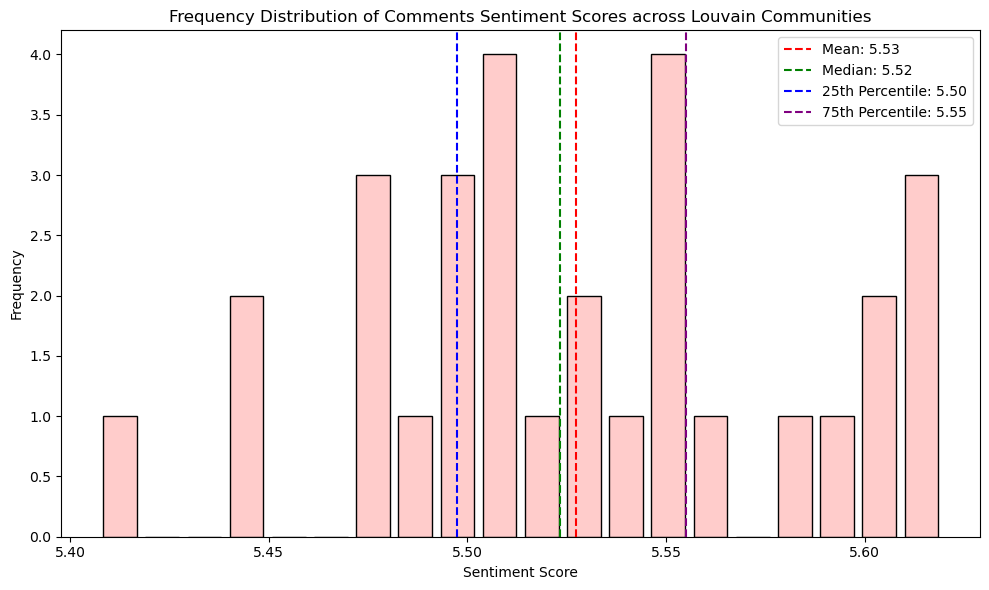

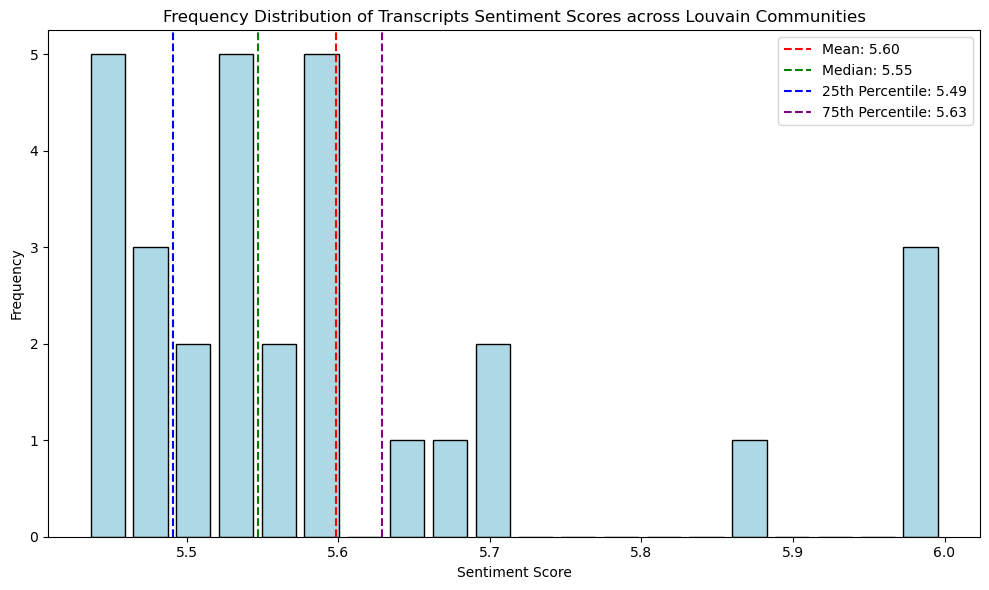

In [134]:
# Helper function to calculate statistics for sentiments
def calculate_statistics(sentiments):
    """Calculate key statistical measures for a list of sentiments."""
    return {
        "Mean": np.mean(sentiments),
        "Median": np.median(sentiments),
        "Variance": np.var(sentiments),
        "Min": min(sentiments),
        "Max": max(sentiments),
        "25th Percentile": np.percentile(sentiments, 25),
        "75th Percentile": np.percentile(sentiments, 75)
    }

# Calculate statistics for comments and transcripts
comments_stats = calculate_statistics(list(community_sentiments_comments.values()))
transcripts_stats = calculate_statistics(list(community_sentiments_transcripts.values()))

# Print statistics
def print_statistics(title, stats):
    """Print statistical measures for a given set of sentiments."""
    print(f"\n{title}")
    print("-" * len(title))
    for stat_name, stat_value in stats.items():
        print(f"{stat_name}: {stat_value:.2f}")

print_statistics("Comments Sentiment Statistics across Louvain Communities", comments_stats)
print_statistics("Transcripts Sentiment Statistics across Louvain Communities", transcripts_stats)

# Function to plot frequency distribution with statistics
def plot_sentiment_distribution_with_stats(sentiments, stats, title, color, xlabel='Sentiment Score', ylabel='Frequency'):
    """Plot a frequency distribution of sentiments and overlay statistical measures."""
    # Calculate frequency distribution
    num_bins = 20
    bin_edges = np.linspace(stats["Min"], stats["Max"], num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    frequencies, _ = np.histogram(sentiments, bins=bin_edges)
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.8
    plt.bar(bin_centers, frequencies, width=bar_width, color=color, edgecolor='black')
    
    # Overlay statistics as vertical lines
    for stat, value in stats.items():
        if stat in ["Mean", "Median", "25th Percentile", "75th Percentile"]:
            color_map = {"Mean": 'red', "Median": 'green', "25th Percentile": 'blue', "75th Percentile": 'purple'}
            plt.axvline(value, color=color_map[stat], linestyle='dashed', linewidth=1.5, label=f'{stat}: {value:.2f}')
    
    # Add title, labels, and legend
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot frequency distributions with statistics
plot_sentiment_distribution_with_stats(
    list(community_sentiments_comments.values()),
    comments_stats,
    title='Frequency Distribution of Comments Sentiment Scores across Louvain Communities',
    color='#ffcccb'
)

plot_sentiment_distribution_with_stats(
    list(community_sentiments_transcripts.values()),
    transcripts_stats,
    title='Frequency Distribution of Transcripts Sentiment Scores across Louvain Communities',
    color='#add8e6'
)


### Sentiment Analysis for Comments and Transcripts across Category IDs

In [136]:
# Calculate average sentiments for categories using the `categoryId` attribute
category_avg_sentiments_comments = calculate_average_sentiments(G, sentiment_key='comments_sentiment', attribute_key='categoryId')
category_avg_sentiments_transcripts = calculate_average_sentiments(G, sentiment_key='transcript_sentiment', attribute_key='categoryId')

# Display happiest and saddest categories for comments and transcripts
display_top_groups(
    "Category Sentiment Analysis for Comments",
    category_avg_sentiments_comments,
    mapping=category_mapping,
    group_type="Category"
)

display_top_groups(
    "Category Sentiment Analysis for Transcripts",
    category_avg_sentiments_transcripts,
    mapping=category_mapping,
    group_type="Category"
)



Category Sentiment Analysis for Comments
----------------------------------------

Happiest Groups:
Category Nonprofits & Activism: Average Sentiment = 5.77
Category Music: Average Sentiment = 5.63
Category People & Blogs: Average Sentiment = 5.55

Saddest Groups:
Category Sports: Average Sentiment = 5.45
Category Science & Technology: Average Sentiment = 5.43
Category News & Politics: Average Sentiment = 5.40

Category Sentiment Analysis for Transcripts
-------------------------------------------

Happiest Groups:
Category Music: Average Sentiment = 5.76
Category People & Blogs: Average Sentiment = 5.66
Category Howto & Style: Average Sentiment = 5.63

Saddest Groups:
Category News & Politics: Average Sentiment = 5.43
Category Science & Technology: Average Sentiment = 5.40
Category Travel & Events: Average Sentiment = 5.39



Comments Sentiment Statistics across Categories
-----------------------------------------------
Mean: 5.52
Median: 5.51
Variance: 0.01
Min: 5.40
Max: 5.77
25th Percentile: 5.48
75th Percentile: 5.54

Transcripts Sentiment Statistics across Categories
--------------------------------------------------
Mean: 5.53
Median: 5.47
Variance: 0.01
Min: 5.39
Max: 5.76
25th Percentile: 5.45
75th Percentile: 5.60


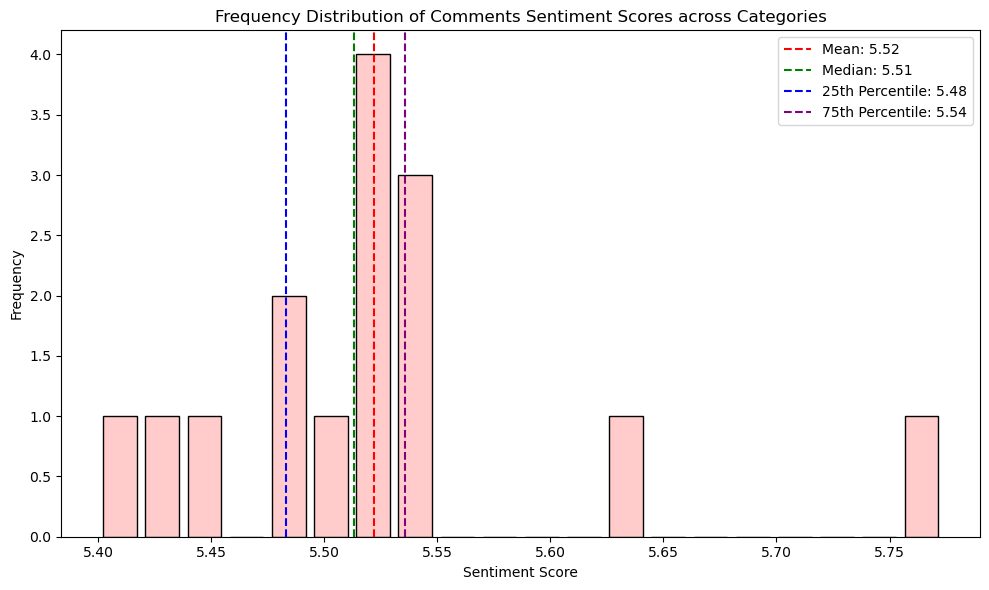

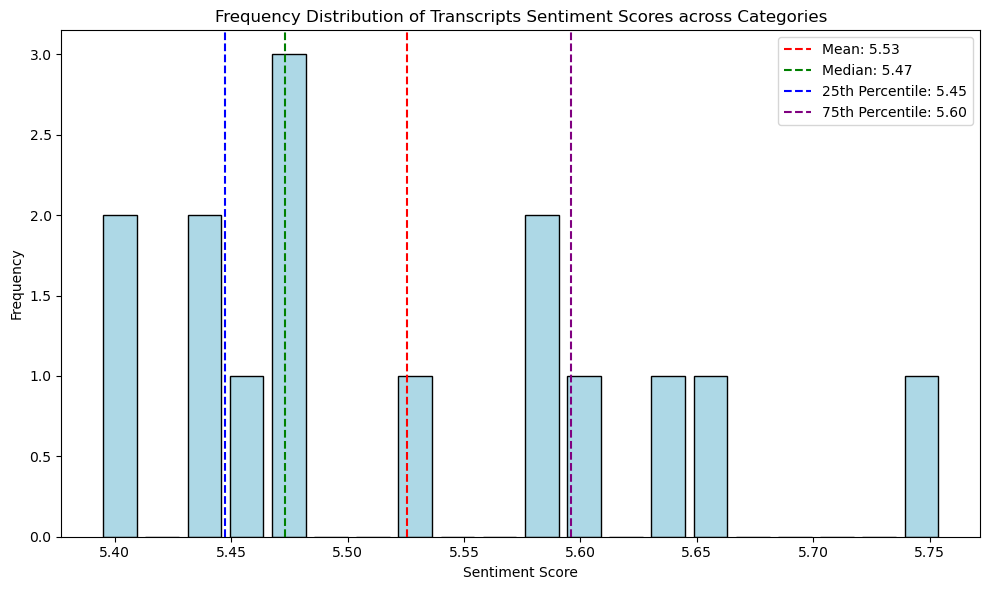

In [137]:
# Calculate statistics for category sentiments
comments_stats_by_category = calculate_statistics(list(category_avg_sentiments_comments.values()))
transcripts_stats_by_category = calculate_statistics(list(category_avg_sentiments_transcripts.values()))

# Print statistics for comments and transcripts by category
print_statistics("Comments Sentiment Statistics across Categories", comments_stats_by_category)
print_statistics("Transcripts Sentiment Statistics across Categories", transcripts_stats_by_category)

# Plot frequency distributions for comments and transcripts by category
plot_sentiment_distribution_with_stats(
    list(category_avg_sentiments_comments.values()),
    comments_stats_by_category,
    title='Frequency Distribution of Comments Sentiment Scores across Categories',
    color='#ffcccb'  # Light pink
)

plot_sentiment_distribution_with_stats(
    list(category_avg_sentiments_transcripts.values()),
    transcripts_stats_by_category,
    title='Frequency Distribution of Transcripts Sentiment Scores across Categories',
    color='#add8e6'  # Light blue
)
